In [1]:
### import necessary packages and libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os

In [57]:
THRESHOLDS = {"s_thresh": (170,255),
             "x_thresh": (30,100),
             "y_thresh": (30,100),
             "mag_thresh": (30, 100),
             "dir_thresh": (0.7, 1.3),
             "kernel_size": 3}
YSCALE = 30 / 720
XSCALE = 3.7 / 700
HEIGHT = 720
WIDTH = 1280

In [56]:
def calibrate_cam(file_names, nx = 9, ny = 6):
    ###get coefficients to undistort camera images
    images = glob.glob(file_names)
    ## create obj point grids
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    img_shape = cv2.imread('./camera_cal/calibration8.jpg').shape

    ## 3D real world points
    obj_points = []
    ## 2D image points
    img_points = []
    for idx, name in enumerate(images):
        img = mpimg.imread(name)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret == True:
            cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
            obj_points.append(objp)
            img_points.append(corners)
    _, mtx, dist, _, _ = cv2.calibrateCamera(obj_points, img_points, 
                                             img_shape[:2],None,None)
    return mtx, dist
def get_pt():
    src = np.float32([[200,720],
                    [1100,720],
                    [570,467],
                    [714,467]])
    dst = np.float32([[360,720],
                  [920,720],
                  [360,0],
                  [920,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)   
    return M, Minv
def undistort_img(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def warped_pt(undist, mtx, dist, M):
    img_size = (undist.shape[1], undist.shape[0])
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size,  flags=cv2.INTER_LINEAR)
    return warped

def unwarp_img(warped, Minv):
    img_size = (warped.shape[1], warped.shape[0])
    # Warp the image using OpenCV warpPerspective()
    unwarped = cv2.warpPerspective(warped, Minv, img_size)
    return unwarped

In [4]:
calibration_files = './camera_cal/calibration*.jpg'
mtx, dist = calibrate_cam(calibration_files, nx = 9, ny = 6)
M, Minv = get_pt()

In [5]:
## Threshold 
def abs_sobel_thresh(grad_sobel, thresh = (0,255)):

    abs_sobel = np.absolute(grad_sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_sobel_thresh_(sobelx, sobely, mag_thresh=(0, 255)):
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output    

def dir_sobel_thresh(sobelx, sobely, thresh=(0, np.pi/2)):
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

def hls_select(s_channel, thresh=(0, 255)):
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

def threshold_binary(img, **kwargs):
    # load thresholds
    sobel_kernel = kwargs['kernel_size']
    s_thresh = kwargs['s_thresh']
    x_thresh = kwargs['x_thresh']
    y_thresh = kwargs['y_thresh']
    mag_thresh = kwargs['mag_thresh']
    dir_thresh = kwargs['dir_thresh']
    # convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # l is essentially grayscale
    l_channel = hls[:,:,1]
    # s for color saturation thresholding
    s_channel = hls[:,:,2]
    
    # apply gradient thhreshold functions
    dx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    dy = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    binary_dx = abs_sobel_thresh(dx, x_thresh)
    binary_dy = abs_sobel_thresh(dy, y_thresh)
    binary_mag = mag_sobel_thresh_(dx, dy, mag_thresh)
    binary_dir = dir_sobel_thresh(dx, dy, mag_thresh)
    
    # combined gradient thresholding
    combined = np.zeros_like(binary_dir)
    binary_idx = (((binary_dx == 1) & (binary_dy == 1)) |
                  ((binary_mag == 1) & (binary_dir == 1)))
    combined[binary_idx] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary = np.zeros_like(s_binary)
    binary[((combined == 1) | (s_binary == 1))] = 1
    
    return binary

In [66]:
def find_poly_thr_window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    return left_fit, right_fit

### given points fit polynomial lines
def fit_polynomial(leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    return left_fit, right_fit
def poly_lines(left_fit, right_fit, warped_img):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit,right_fit):
    margin = 30
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    #extract left and right line pixel positions
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit new polynomials
    if len(leftx) > 20 and len(rightx) > 20:
#         print("newfit")
        new_left_fit, new_right_fit = fit_polynomial(leftx, lefty, rightx, righty)
        return new_left_fit, new_right_fit
    else:
        new_left_fit, new_right_fit = find_poly_thr_window(binary_warped)
        if np.linalg(new_left_fit - left_fit) > 10 or np.linalg(new_right_fit - right_fit) > 10:
            return left_fit, right_fit
        return new_left_fit, new_right_fit
    
def scaled_fit(lane_fit):
    res = [0, 0, 0]
    try:
        res[0] = XSCALE/(YSCALE**2)*lane_fit[0]
        res[1] = XSCALE/YSCALE*lane_fit[1]
        res[2] = lane_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('Failed to convert to real world scale')
def get_curvature(left_fit, right_fit):
    
    left_curverad = (1 + (2*(HEIGHT -1 )*left_fit[0] + left_fit[1])**2)**1.5/(2*np.absolute(left_fit[0]))
    right_curverad = (1 + (2*(HEIGHT -1 )*right_fit[0] + right_fit[1])**2)**1.5/(2*np.absolute(right_fit[0]))
    return (left_curverad+ right_curverad) /2
def get_center(left_fitx, right_fitx):
    center = WIDTH//2
    dist = (left_fitx[-1] + right_fitx[-1])/2 - center
    if dist >= 0:
        direct = 'Right'
    else:
        direct = 'Left'
    return dist*XSCALE, direct  

def shade_road(warped_img,left_fitx, right_fitx, ploty):
    width, height =warped_img.shape[0:2]
    canvas = np.zeros((width, height,3))
    left_points = np.stack((left_fitx,ploty), axis = 1)
    right_points = np.stack((right_fitx,ploty), axis = 1)
    right_points = np.flip(right_points, axis = 0)
    lanePoints = np.vstack((left_points,right_points)).astype(int)

    cv2.fillPoly(canvas,[lanePoints],(0,255, 0))
#     plt.plot(left_fitx+12, ploty, color='yellow', linewidth = 8)
#     plt.plot(right_fitx-12, ploty, color='yellow', linewidth = 8)
    for point in lanePoints:
        canvas[point[1], point[0]-6:point[0]+6,:] = [255,0,0]
    
    return canvas

def lane_mask(binary_warped):
    global left_polyfit, right_polyfit 
    print(left_polyfit)
    if left_polyfit.any() & right_polyfit.any():
        left_fit, right_fit = search_around_poly(binary_warped,
                                                 left_polyfit, right_polyfit)
        left_polyfit, right_polyfit = left_fit, right_fit
    else:
        print("Search through Sliding Windows")
        left_fit, right_fit = find_poly_thr_window(binary_warped)
        left_polyfit, right_polyfit = left_fit, right_fit
    left_fitx, right_fitx, ploty = poly_lines(left_polyfit, right_polyfit,
                                              binary_warped)
    mask = shade_road(binary_warped,left_fitx, right_fitx, ploty)
    center,direct = get_center(left_fitx,right_fitx)
    curvature = get_curvature(left_fit,right_fit)
    return mask, (center,direct,curvature)
    

def add_loc_info(masked_img,loc_info):
    """
    add location and curavature information to the output image
    """
    center,direct,curvature = loc_info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255,255,255)

    cv2.putText(masked_img,
                "Radius of Curvature = {:.3f}(m)".format(curvature),
                (20,40),font, 1, fontColor,3)
    cv2.putText(masked_img,
                "Vehicle is {:.3f} m {} of the Center".format(center, direct),
                (20,100),font, 1, fontColor,3)
    return masked_img

In [30]:
def ad_lane_pipline(img):
    undist = undistort_img(img,mtx,dist)
    binary = threshold_binary(undist,**THRESHOLDS)
    binary_warped = warped_pt(binary, mtx, dist, M)
    mask, loc_info = lane_mask(binary_warped)
    unwarped_mask = unwarp_img(mask, Minv)
    masked_img = cv2.addWeighted(undist,1,unwarped_mask,0.3,
                                 0,dtype=cv2.CV_8UC1)
    masked_img = add_loc_info(masked_img,loc_info)
    
#     return binary_warped
    return masked_img

#     plt.imshow(binary_warped,cmap = 'gray')


Search through Sliding Windows


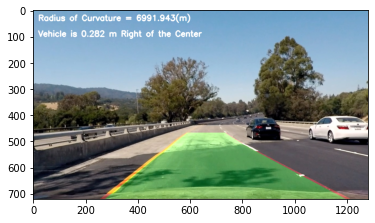

In [55]:
left_polyfit, right_polyfit = np.array([]), np.array([])
test_img = mpimg.imread('./test_images/test4.jpg')
plt.imshow(ad_lane_pipline(test_img))

In [9]:
# Import packages to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [67]:
left_polyfit, right_polyfit = np.array([]), np.array([])


test_output = 'test_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

# plt.imshow(ad_lane_pipline(freame))
test_clip = clip1.fl_image(ad_lane_pipline)
%time test_clip.write_videofile('tutorial.mp4',audio = False)




                                                      

t:  24%|██▍       | 12/50 [28:07<00:08,  4.32it/s, now=None]

                                                      

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]w=None]

[]
Search through Sliding Windows
Moviepy - Building video tutorial.mp4.
Moviepy - Writing video tutorial.mp4

[-1.24108337e-04  1.72616410e-01  3.50854344e+02]


t:   0%|          | 4/1260 [00:00<03:40,  5.71it/s, now=None]

[-1.18588148e-04  1.70870608e-01  3.50887601e+02]
[-1.25628047e-04  1.76338927e-01  3.50741601e+02]


t:   0%|          | 5/1260 [00:00<03:45,  5.56it/s, now=None]

[-1.41199268e-04  1.87383069e-01  3.50384950e+02]
[-1.50402314e-04  1.96035502e-01  3.49229686e+02]


t:   1%|          | 7/1260 [00:01<03:53,  5.38it/s, now=None]

[-1.62623634e-04  2.08821494e-01  3.46661380e+02]
[-1.58812226e-04  2.10013839e-01  3.45922750e+02]


t:   1%|          | 9/1260 [00:01<03:52,  5.37it/s, now=None]

[-1.42242928e-04  2.01457946e-01  3.45415143e+02]
[-1.52231544e-04  2.12060105e-01  3.44197811e+02]


t:   1%|          | 11/1260 [00:02<04:02,  5.14it/s, now=None]

[-1.39835274e-04  2.05653532e-01  3.42648273e+02]
[-1.45668249e-04  2.16122018e-01  3.37683860e+02]


t:   1%|          | 13/1260 [00:02<03:54,  5.31it/s, now=None]

[-1.48075897e-04  2.20517128e-01  3.35961241e+02]
[-1.50183843e-04  2.28805028e-01  3.29162279e+02]


t:   1%|          | 15/1260 [00:02<03:56,  5.27it/s, now=None]

[-1.36066876e-04  2.20380152e-01  3.29519759e+02]
[-1.31622384e-04  2.19493497e-01  3.28259204e+02]


t:   1%|▏         | 18/1260 [00:03<03:49,  5.41it/s, now=None]

[-1.24760553e-04  2.12900385e-01  3.30863488e+02]
[-1.13280579e-04  2.01352826e-01  3.34243216e+02]


t:   2%|▏         | 19/1260 [00:03<03:46,  5.48it/s, now=None]

[-1.17579991e-04  2.05330358e-01  3.32242664e+02]
[-1.16773244e-04  2.04997959e-01  3.32126349e+02]


t:   2%|▏         | 21/1260 [00:03<03:48,  5.43it/s, now=None]

[-1.03079785e-04  1.95744059e-01  3.31036719e+02]


t:   2%|▏         | 22/1260 [00:04<03:56,  5.23it/s, now=None]

[-8.61952930e-05  1.85338381e-01  3.29729072e+02]
[-7.63629466e-05  1.80415989e-01  3.27818044e+02]


t:   2%|▏         | 25/1260 [00:04<03:44,  5.50it/s, now=None]

[-6.41333607e-05  1.72335649e-01  3.25853182e+02]
[-6.55920936e-05  1.73730487e-01  3.23134663e+02]


t:   2%|▏         | 26/1260 [00:04<03:47,  5.43it/s, now=None]

[-6.46681840e-05  1.65714966e-01  3.26791691e+02]
[-6.91065791e-05  1.64018971e-01  3.28315772e+02]


t:   2%|▏         | 29/1260 [00:05<03:42,  5.54it/s, now=None]

[-7.78928291e-05  1.71562952e-01  3.24897518e+02]
[-8.00426069e-05  1.70889112e-01  3.25102714e+02]


t:   2%|▏         | 30/1260 [00:05<03:41,  5.54it/s, now=None]

[-7.73181798e-05  1.66583247e-01  3.24108396e+02]
[-8.51876575e-05  1.67556359e-01  3.26619480e+02]


t:   3%|▎         | 32/1260 [00:05<03:54,  5.23it/s, now=None]

[-1.15381374e-04  1.83599895e-01  3.28026688e+02]
[-1.20823435e-04  1.84205072e-01  3.30902013e+02]


t:   3%|▎         | 34/1260 [00:06<03:50,  5.32it/s, now=None]

[-1.27438055e-04  1.83670712e-01  3.35332297e+02]
[-1.26806676e-04  1.85867166e-01  3.33134617e+02]


t:   3%|▎         | 36/1260 [00:06<03:47,  5.38it/s, now=None]

[-1.40831113e-04  1.95204297e-01  3.33750061e+02]
[-1.42750673e-04  1.97095182e-01  3.34546343e+02]


t:   3%|▎         | 38/1260 [00:07<03:54,  5.21it/s, now=None]

[-1.47457513e-04  2.01439286e-01  3.35577026e+02]
[-1.50810442e-04  2.05853890e-01  3.35142432e+02]


t:   3%|▎         | 41/1260 [00:07<03:36,  5.62it/s, now=None]

[-1.56431991e-04  2.09874877e-01  3.35955353e+02]
[-1.67537403e-04  2.19801908e-01  3.35123457e+02]


t:   3%|▎         | 42/1260 [00:07<03:42,  5.48it/s, now=None]

[-1.71194443e-04  2.26559218e-01  3.32445188e+02]
[-1.75350800e-04  2.32038733e-01  3.31223234e+02]


t:   4%|▎         | 45/1260 [00:08<03:39,  5.53it/s, now=None]

[-1.71992048e-04  2.31166446e-01  3.31054101e+02]
[-1.81836209e-04  2.43367918e-01  3.27539485e+02]


t:   4%|▎         | 47/1260 [00:08<03:33,  5.69it/s, now=None]

[-1.76576693e-04  2.42526370e-01  3.25674521e+02]
[-1.76986484e-04  2.48172751e-01  3.22389867e+02]


t:   4%|▍         | 48/1260 [00:08<03:36,  5.59it/s, now=None]

[-1.79007816e-04  2.51561041e-01  3.20959818e+02]
[-1.69454257e-04  2.46670445e-01  3.19872746e+02]


t:   4%|▍         | 51/1260 [00:09<03:32,  5.69it/s, now=None]

[-1.83982161e-04  2.62854096e-01  3.15675365e+02]
[-1.76382840e-04  2.61819712e-01  3.12437072e+02]


t:   4%|▍         | 52/1260 [00:09<03:37,  5.56it/s, now=None]

[-1.66454952e-04  2.57296839e-01  3.11904628e+02]
[-1.56299049e-04  2.52519905e-01  3.10978977e+02]


t:   4%|▍         | 54/1260 [00:09<03:43,  5.39it/s, now=None]

[-1.53357393e-04  2.50341868e-01  3.11847433e+02]
[-1.36491787e-04  2.37385526e-01  3.13524503e+02]


t:   4%|▍         | 56/1260 [00:10<03:34,  5.61it/s, now=None]

[-1.21518958e-04  2.25612508e-01  3.14705071e+02]
[-1.13183997e-04  2.20441656e-01  3.13811274e+02]


t:   5%|▍         | 58/1260 [00:10<03:45,  5.32it/s, now=None]

[-9.71331444e-05  2.08102850e-01  3.14407485e+02]
[-9.09640988e-05  2.02012243e-01  3.15184955e+02]


t:   5%|▍         | 60/1260 [00:11<03:47,  5.27it/s, now=None]

[-7.86649584e-05  1.91034012e-01  3.16450674e+02]
[-7.40330461e-05  1.80802613e-01  3.21465164e+02]


t:   5%|▌         | 63/1260 [00:11<03:34,  5.59it/s, now=None]

[-6.78000892e-05  1.69573036e-01  3.25988914e+02]
[-6.95964167e-05  1.66700713e-01  3.27447421e+02]


t:   5%|▌         | 64/1260 [00:11<03:33,  5.59it/s, now=None]

[-8.19057886e-05  1.71740702e-01  3.28598839e+02]
[-8.18622862e-05  1.69424135e-01  3.28365301e+02]


t:   5%|▌         | 67/1260 [00:12<03:32,  5.62it/s, now=None]

[-9.49801070e-05  1.74316926e-01  3.29900070e+02]
[-1.04901130e-04  1.80910309e-01  3.27745283e+02]


t:   5%|▌         | 68/1260 [00:12<03:31,  5.64it/s, now=None]

[-1.19888663e-04  1.88019527e-01  3.28589184e+02]
[-1.24237764e-04  1.90389959e-01  3.27906349e+02]


t:   6%|▌         | 70/1260 [00:12<03:33,  5.58it/s, now=None]

[-1.31008238e-04  1.94614373e-01  3.25908556e+02]
[-1.45379289e-04  2.03595508e-01  3.26066255e+02]


t:   6%|▌         | 72/1260 [00:13<03:30,  5.64it/s, now=None]

[-1.48319610e-04  2.08415053e-01  3.22692979e+02]
[-1.54730923e-04  2.14093239e-01  3.21901379e+02]


t:   6%|▌         | 74/1260 [00:13<03:28,  5.69it/s, now=None]

[-1.41267526e-04  2.06296172e-01  3.20832893e+02]
[-1.26262208e-04  1.97931886e-01  3.19978262e+02]


t:   6%|▌         | 76/1260 [00:13<03:29,  5.65it/s, now=None]

[-1.13457392e-04  1.89393167e-01  3.20283988e+02]
[-9.45607787e-05  1.78049634e-01  3.18895028e+02]


t:   6%|▋         | 79/1260 [00:14<03:24,  5.77it/s, now=None]

[-8.90749438e-05  1.74001305e-01  3.19478778e+02]
[-6.48653692e-05  1.61170233e-01  3.16057307e+02]


t:   6%|▋         | 80/1260 [00:14<03:26,  5.71it/s, now=None]

[-5.28150194e-05  1.53147057e-01  3.15269210e+02]
[-3.88557844e-05  1.42399032e-01  3.14695803e+02]


t:   7%|▋         | 82/1260 [00:14<03:34,  5.49it/s, now=None]

[-2.84537502e-05  1.30461915e-01  3.16714847e+02]
[-3.02294749e-05  1.25967838e-01  3.18955814e+02]


t:   7%|▋         | 85/1260 [00:15<03:24,  5.75it/s, now=None]

[-2.90254856e-05  1.22372098e-01  3.18672526e+02]
[-3.19289395e-05  1.20649141e-01  3.18933565e+02]


t:   7%|▋         | 86/1260 [00:15<03:26,  5.69it/s, now=None]

[-2.83616795e-05  1.20633309e-01  3.14592708e+02]
[-3.37933759e-05  1.19747084e-01  3.16253900e+02]


t:   7%|▋         | 88/1260 [00:16<03:36,  5.42it/s, now=None]

[-4.89200342e-05  1.26690378e-01  3.17128000e+02]
[-5.80716833e-05  1.21980545e-01  3.25475047e+02]


t:   7%|▋         | 91/1260 [00:16<03:24,  5.72it/s, now=None]

[-7.33190056e-05  1.26125084e-01  3.29883827e+02]
[-9.14907719e-05  1.34909520e-01  3.32249877e+02]


t:   7%|▋         | 92/1260 [00:16<03:27,  5.63it/s, now=None]

[-1.07486473e-04  1.41734821e-01  3.36761708e+02]
[-1.13974834e-04  1.49230764e-01  3.34145312e+02]


t:   8%|▊         | 95/1260 [00:17<03:34,  5.44it/s, now=None]

[-1.17996769e-04  1.53698594e-01  3.33479595e+02]
[-1.23881222e-04  1.54336709e-01  3.36776520e+02]


t:   8%|▊         | 96/1260 [00:17<03:29,  5.57it/s, now=None]

[-1.34305966e-04  1.64095790e-01  3.36211148e+02]
[-1.29475743e-04  1.62128898e-01  3.35093578e+02]


t:   8%|▊         | 98/1260 [00:17<03:29,  5.55it/s, now=None]

[-1.37689333e-04  1.70176482e-01  3.33600110e+02]
[-1.32547397e-04  1.67551292e-01  3.34349000e+02]


t:   8%|▊         | 101/1260 [00:18<03:19,  5.80it/s, now=None]

[-1.29424930e-04  1.69769917e-01  3.31440735e+02]
[-1.22967321e-04  1.64070192e-01  3.34029134e+02]


t:   8%|▊         | 102/1260 [00:18<03:21,  5.74it/s, now=None]

[-1.19758229e-04  1.64936963e-01  3.32386334e+02]
[-1.20478277e-04  1.65478503e-01  3.33646588e+02]


t:   8%|▊         | 104/1260 [00:18<03:31,  5.48it/s, now=None]

[-1.12326650e-04  1.58641882e-01  3.35926054e+02]
[-1.10521413e-04  1.57630667e-01  3.36378233e+02]


t:   8%|▊         | 107/1260 [00:19<03:23,  5.66it/s, now=None]

[-1.11317927e-04  1.59031987e-01  3.36963929e+02]
[-1.00040259e-04  1.52761203e-01  3.35775970e+02]


t:   9%|▊         | 108/1260 [00:19<03:23,  5.67it/s, now=None]

[-1.05127848e-04  1.57351282e-01  3.34550046e+02]
[-1.08944097e-04  1.63520315e-01  3.32038501e+02]


t:   9%|▉         | 111/1260 [00:20<03:25,  5.59it/s, now=None]

[-1.17280026e-04  1.66597172e-01  3.35532742e+02]
[-1.19440255e-04  1.67060504e-01  3.36424599e+02]


t:   9%|▉         | 112/1260 [00:20<03:21,  5.69it/s, now=None]

[-1.29833069e-04  1.76322622e-01  3.34908017e+02]
[-1.28446580e-04  1.73501091e-01  3.36985294e+02]


t:   9%|▉         | 114/1260 [00:20<03:22,  5.65it/s, now=None]

[-1.23977900e-04  1.73944575e-01  3.33743946e+02]
[-1.25423261e-04  1.73314705e-01  3.36817182e+02]


t:   9%|▉         | 116/1260 [00:21<03:28,  5.48it/s, now=None]

[-1.25963434e-04  1.71740770e-01  3.38839809e+02]
[-1.31277737e-04  1.74171369e-01  3.41318382e+02]


t:   9%|▉         | 118/1260 [00:21<03:21,  5.68it/s, now=None]

[-1.34457214e-04  1.76508692e-01  3.41845109e+02]
[-1.36145897e-04  1.79796703e-01  3.40648732e+02]


t:  10%|▉         | 120/1260 [00:21<03:21,  5.65it/s, now=None]

[-1.39965890e-04  1.83091140e-01  3.40805528e+02]
[-1.43437573e-04  1.86887098e-01  3.40583741e+02]


t:  10%|▉         | 122/1260 [00:22<03:31,  5.39it/s, now=None]

[-1.54852202e-04  1.96030914e-01  3.41243878e+02]
[-1.55421587e-04  2.00079571e-01  3.39490866e+02]


t:  10%|▉         | 125/1260 [00:22<03:17,  5.74it/s, now=None]

[-1.60109090e-04  2.05583619e-01  3.39105362e+02]
[-1.64818784e-04  2.08850236e-01  3.40428947e+02]


t:  10%|█         | 126/1260 [00:22<03:19,  5.68it/s, now=None]

[-1.65201434e-04  2.10735757e-01  3.40191259e+02]


t:  10%|█         | 127/1260 [00:23<03:30,  5.37it/s, now=None]

[-1.63733119e-04  2.10494869e-01  3.40884459e+02]
[-1.56583960e-04  2.10213343e-01  3.37743858e+02]


t:  10%|█         | 130/1260 [00:23<03:14,  5.80it/s, now=None]

[-1.53557253e-04  2.08357268e-01  3.38766041e+02]
[-1.52916945e-04  2.11685533e-01  3.36765294e+02]


t:  10%|█         | 132/1260 [00:23<03:19,  5.65it/s, now=None]

[-1.53155021e-04  2.11783383e-01  3.39011747e+02]
[-1.54700744e-04  2.14130632e-01  3.37442324e+02]


t:  11%|█         | 134/1260 [00:24<03:20,  5.61it/s, now=None]

[-1.44050898e-04  2.06614717e-01  3.38666026e+02]
[-1.47125474e-04  2.11012303e-01  3.38668095e+02]


t:  11%|█         | 135/1260 [00:24<03:19,  5.65it/s, now=None]

[-1.41696893e-04  2.06868658e-01  3.39469887e+02]
[-1.36331495e-04  2.04089183e-01  3.40337049e+02]


t:  11%|█         | 137/1260 [00:24<03:19,  5.63it/s, now=None]

[-1.24779498e-04  1.96996877e-01  3.40894962e+02]
[-1.20111709e-04  1.94589420e-01  3.40686793e+02]


t:  11%|█         | 140/1260 [00:25<03:17,  5.68it/s, now=None]

[-1.09841894e-04  1.86671954e-01  3.40927545e+02]
[-1.03976066e-04  1.82835940e-01  3.39642899e+02]


t:  11%|█         | 141/1260 [00:25<03:17,  5.67it/s, now=None]

[-1.02790971e-04  1.80849523e-01  3.39529836e+02]
[-9.34782127e-05  1.74948901e-01  3.37729465e+02]


t:  11%|█▏        | 143/1260 [00:25<03:21,  5.55it/s, now=None]

[-9.24174659e-05  1.73079786e-01  3.38220793e+02]
[-9.23385711e-05  1.71603677e-01  3.38573074e+02]


t:  12%|█▏        | 145/1260 [00:26<03:21,  5.53it/s, now=None]

[-1.09018965e-04  1.79227133e-01  3.40158360e+02]
[-1.18667692e-04  1.85366506e-01  3.39259704e+02]


t:  12%|█▏        | 147/1260 [00:26<03:19,  5.58it/s, now=None]

[-1.21086193e-04  1.85834205e-01  3.39300890e+02]
[-1.21011073e-04  1.83729898e-01  3.41095611e+02]


t:  12%|█▏        | 149/1260 [00:26<03:23,  5.47it/s, now=None]

[-1.18522609e-04  1.82114509e-01  3.41179479e+02]
[-1.08826373e-04  1.68816929e-01  3.48326851e+02]


t:  12%|█▏        | 151/1260 [00:27<03:21,  5.50it/s, now=None]

[-1.02352238e-04  1.63781223e-01  3.49373927e+02]
[-9.20008835e-05  1.57894594e-01  3.48591551e+02]


t:  12%|█▏        | 153/1260 [00:27<03:20,  5.53it/s, now=None]

[-8.89563591e-05  1.57400124e-01  3.46953235e+02]
[-8.48232449e-05  1.54917756e-01  3.45361826e+02]


t:  12%|█▏        | 156/1260 [00:28<03:16,  5.61it/s, now=None]

[-8.15190454e-05  1.50770937e-01  3.47308274e+02]
[-7.63984517e-05  1.49866591e-01  3.44214932e+02]


t:  13%|█▎        | 158/1260 [00:28<03:12,  5.72it/s, now=None]

[-8.34489287e-05  1.56284666e-01  3.40967783e+02]
[-7.93607049e-05  1.53542166e-01  3.40291916e+02]


t:  13%|█▎        | 159/1260 [00:28<03:15,  5.64it/s, now=None]

[-8.46635813e-05  1.56550889e-01  3.39293221e+02]
[-1.05223332e-04  1.69474254e-01  3.39111876e+02]


t:  13%|█▎        | 162/1260 [00:29<03:21,  5.44it/s, now=None]

[-1.10990638e-04  1.75073659e-01  3.35950565e+02]
[-1.15913734e-04  1.78012665e-01  3.35443186e+02]


t:  13%|█▎        | 163/1260 [00:29<03:16,  5.58it/s, now=None]

[-1.15289911e-04  1.82197912e-01  3.31052215e+02]
[-1.22881649e-04  1.89864828e-01  3.28148952e+02]


t:  13%|█▎        | 165/1260 [00:29<03:20,  5.47it/s, now=None]

[-1.20511306e-04  1.91015573e-01  3.25241233e+02]
[-1.30219117e-04  1.97546642e-01  3.25385044e+02]


t:  13%|█▎        | 167/1260 [00:30<03:18,  5.50it/s, now=None]

[-1.28667637e-04  1.94623183e-01  3.27707431e+02]
[-1.24635512e-04  1.94415384e-01  3.25574810e+02]


t:  13%|█▎        | 170/1260 [00:30<03:10,  5.71it/s, now=None]

[-1.31126878e-04  1.97473801e-01  3.26539760e+02]
[-1.28363941e-04  2.02389941e-01  3.21001570e+02]


t:  14%|█▎        | 171/1260 [00:30<03:13,  5.64it/s, now=None]

[-1.26266059e-04  2.04321087e-01  3.17943777e+02]
[-1.21403202e-04  2.03624920e-01  3.14292827e+02]


t:  14%|█▍        | 174/1260 [00:31<03:09,  5.73it/s, now=None]

[-1.15679615e-04  2.01958475e-01  3.12461828e+02]
[-1.15745327e-04  2.02090349e-01  3.11642659e+02]


t:  14%|█▍        | 175/1260 [00:31<03:08,  5.77it/s, now=None]

[-1.04931940e-04  1.91587052e-01  3.13653897e+02]
[-8.96957906e-05  1.75439687e-01  3.18392363e+02]


t:  14%|█▍        | 177/1260 [00:32<03:12,  5.62it/s, now=None]

[-8.30878043e-05  1.68342624e-01  3.20300953e+02]
[-8.19348264e-05  1.64922646e-01  3.21071889e+02]


t:  14%|█▍        | 180/1260 [00:32<03:05,  5.83it/s, now=None]

[-7.36588539e-05  1.63559866e-01  3.16890930e+02]
[-6.46393030e-05  1.54999110e-01  3.17975565e+02]


t:  14%|█▍        | 181/1260 [00:32<03:06,  5.80it/s, now=None]

[-6.64384028e-05  1.54434831e-01  3.18606475e+02]
[-7.25229907e-05  1.56568967e-01  3.18281290e+02]


t:  15%|█▍        | 184/1260 [00:33<03:12,  5.60it/s, now=None]

[-8.99934648e-05  1.63665445e-01  3.20884221e+02]
[-9.49572370e-05  1.64096852e-01  3.20686852e+02]


t:  15%|█▍        | 186/1260 [00:33<03:04,  5.81it/s, now=None]

[-1.20612606e-04  1.77672831e-01  3.22503959e+02]
[-1.39947063e-04  1.88668298e-01  3.23793762e+02]


t:  15%|█▍        | 187/1260 [00:33<03:08,  5.68it/s, now=None]

[-1.50506527e-04  1.92027050e-01  3.26423469e+02]
[-1.77660877e-04  2.07533200e-01  3.30120305e+02]


t:  15%|█▌        | 189/1260 [00:34<03:17,  5.42it/s, now=None]

[-1.88003305e-04  2.16972890e-01  3.29151012e+02]
[-1.97731236e-04  2.24883369e-01  3.30024904e+02]


t:  15%|█▌        | 192/1260 [00:34<03:08,  5.68it/s, now=None]

[-1.95648739e-04  2.26383445e-01  3.29802116e+02]
[-1.95231878e-04  2.28935130e-01  3.30106795e+02]


t:  15%|█▌        | 193/1260 [00:34<03:14,  5.50it/s, now=None]

[-1.93364400e-04  2.29490748e-01  3.31750712e+02]
[-1.91290205e-04  2.34115240e-01  3.29237644e+02]


t:  16%|█▌        | 196/1260 [00:35<03:06,  5.71it/s, now=None]

[-1.90036283e-04  2.36861382e-01  3.29852413e+02]
[-1.76792800e-04  2.29695257e-01  3.30544648e+02]


t:  16%|█▌        | 197/1260 [00:35<03:08,  5.63it/s, now=None]

[-1.67285038e-04  2.24157789e-01  3.30695500e+02]
[-1.51051768e-04  2.18975920e-01  3.24783992e+02]


t:  16%|█▌        | 199/1260 [00:35<03:14,  5.44it/s, now=None]

[-1.43714348e-04  2.19548755e-01  3.18229281e+02]
[-1.27527103e-04  2.14541187e-01  3.11763394e+02]


t:  16%|█▌        | 202/1260 [00:36<03:03,  5.77it/s, now=None]

[-1.24908983e-04  2.18359663e-01  3.05026440e+02]
[-1.20632843e-04  2.14135479e-01  3.05572728e+02]


t:  16%|█▌        | 203/1260 [00:36<03:01,  5.83it/s, now=None]

[-1.13663746e-04  2.09647225e-01  3.03796878e+02]
[-1.08971986e-04  2.01277189e-01  3.07047136e+02]


t:  16%|█▋        | 205/1260 [00:37<03:09,  5.56it/s, now=None]

[-1.08078888e-04  1.96791670e-01  3.09399055e+02]
[-1.09466691e-04  1.96531292e-01  3.08870449e+02]


t:  16%|█▋        | 207/1260 [00:37<03:10,  5.54it/s, now=None]

[-1.07082175e-04  1.90223948e-01  3.12997444e+02]
[-1.05143480e-04  1.86710644e-01  3.15232815e+02]


t:  17%|█▋        | 209/1260 [00:37<03:09,  5.55it/s, now=None]

[-1.21523779e-04  1.93244659e-01  3.19697386e+02]
[-1.32574478e-04  1.99147473e-01  3.21469113e+02]


t:  17%|█▋        | 211/1260 [00:38<03:16,  5.34it/s, now=None]

[-1.26383662e-04  1.97794547e-01  3.19482794e+02]
[-1.19431412e-04  1.94505597e-01  3.18149571e+02]


t:  17%|█▋        | 213/1260 [00:38<03:07,  5.57it/s, now=None]

[-1.24087993e-04  2.02967394e-01  3.12912787e+02]
[-1.32606356e-04  2.08906678e-01  3.12751974e+02]


t:  17%|█▋        | 215/1260 [00:38<03:04,  5.65it/s, now=None]

[-1.42177379e-04  2.16135207e-01  3.11321015e+02]
[-1.45996077e-04  2.18797055e-01  3.11193051e+02]


t:  17%|█▋        | 218/1260 [00:39<03:03,  5.67it/s, now=None]

[-1.53601145e-04  2.24225143e-01  3.10275798e+02]
[-1.59246568e-04  2.30530932e-01  3.07751814e+02]


t:  17%|█▋        | 219/1260 [00:39<03:00,  5.76it/s, now=None]

[-1.60619081e-04  2.31516515e-01  3.07332961e+02]
[-1.56559951e-04  2.33094124e-01  3.03405384e+02]


t:  18%|█▊        | 221/1260 [00:39<03:02,  5.68it/s, now=None]

[-1.65415618e-04  2.40365562e-01  3.03459682e+02]
[-1.53044193e-04  2.36427518e-01  2.99805510e+02]


t:  18%|█▊        | 224/1260 [00:40<02:59,  5.76it/s, now=None]

[-1.47582113e-04  2.36268588e-01  2.98101407e+02]
[-1.39968147e-04  2.31660656e-01  2.98015912e+02]


t:  18%|█▊        | 225/1260 [00:40<03:02,  5.68it/s, now=None]

[-1.28229695e-04  2.24339287e-01  2.97745354e+02]
[-1.33765704e-04  2.24950526e-01  3.00892076e+02]


t:  18%|█▊        | 227/1260 [00:40<03:03,  5.63it/s, now=None]

[-1.26520444e-04  2.20514164e-01  2.99641552e+02]
[-1.30819655e-04  2.20223228e-01  3.01637682e+02]


t:  18%|█▊        | 229/1260 [00:41<03:04,  5.58it/s, now=None]

[-1.28588931e-04  2.20531347e-01  2.99566045e+02]
[-1.13816684e-04  2.10346529e-01  2.98731079e+02]


t:  18%|█▊        | 232/1260 [00:41<03:00,  5.71it/s, now=None]

[-1.23990535e-04  2.18485101e-01  2.96385465e+02]
[-1.13390825e-04  2.13410145e-01  2.93163698e+02]


t:  18%|█▊        | 233/1260 [00:42<03:06,  5.51it/s, now=None]

[-1.10589167e-04  2.10792474e-01  2.93327920e+02]
[-1.04771140e-04  2.08543131e-01  2.89993188e+02]


t:  19%|█▊        | 236/1260 [00:42<02:56,  5.80it/s, now=None]

[-1.04226771e-04  2.07626321e-01  2.88891567e+02]
[-9.23428727e-05  1.97569679e-01  2.89350873e+02]


t:  19%|█▉        | 237/1260 [00:42<02:54,  5.86it/s, now=None]

[-8.94013736e-05  1.92739657e-01  2.89577549e+02]
[-9.41614539e-05  1.89988733e-01  2.93599026e+02]


t:  19%|█▉        | 239/1260 [00:43<03:07,  5.45it/s, now=None]

[-9.39433595e-05  1.88858070e-01  2.92906800e+02]
[-9.62592027e-05  1.87420521e-01  2.94482410e+02]


t:  19%|█▉        | 242/1260 [00:43<02:53,  5.85it/s, now=None]

[-8.42618136e-05  1.73407925e-01  2.98073482e+02]
[-9.77035739e-05  1.84212301e-01  2.95523460e+02]


t:  19%|█▉        | 244/1260 [00:43<02:55,  5.79it/s, now=None]

[-9.72636263e-05  1.81646947e-01  2.96129231e+02]
[-8.98976594e-05  1.77141912e-01  2.93650798e+02]


t:  20%|█▉        | 246/1260 [00:44<02:59,  5.66it/s, now=None]

[-1.04784034e-04  1.83438225e-01  2.96406568e+02]
[-1.08960300e-04  1.87371282e-01  2.94529659e+02]


t:  20%|█▉        | 248/1260 [00:44<02:52,  5.87it/s, now=None]

[-1.17193882e-04  1.89226034e-01  2.96476331e+02]
[-1.21228221e-04  1.89662037e-01  2.97545767e+02]


t:  20%|█▉        | 249/1260 [00:44<02:56,  5.74it/s, now=None]

[-1.18652847e-04  1.88042250e-01  2.96385618e+02]
[-1.25177850e-04  1.89379529e-01  2.99718680e+02]


t:  20%|█▉        | 251/1260 [00:45<03:08,  5.35it/s, now=None]

[-1.23231117e-04  1.90296911e-01  2.97287779e+02]
[-1.28161372e-04  1.93739293e-01  2.97471107e+02]


t:  20%|██        | 254/1260 [00:45<02:54,  5.75it/s, now=None]

[-1.16625374e-04  1.85652040e-01  2.97339047e+02]
[-1.06175508e-04  1.78546242e-01  2.97641971e+02]


t:  20%|██        | 255/1260 [00:45<03:00,  5.56it/s, now=None]

[-1.15629635e-04  1.83694649e-01  2.97687157e+02]
[-1.04119190e-04  1.76097235e-01  2.97243901e+02]


t:  20%|██        | 258/1260 [00:46<02:57,  5.66it/s, now=None]

[-1.13116180e-04  1.77713636e-01  3.01048327e+02]
[-1.14933945e-04  1.77870742e-01  3.01322647e+02]


t:  21%|██        | 260/1260 [00:46<02:53,  5.76it/s, now=None]

[-1.13848867e-04  1.72596846e-01  3.05047912e+02]
[-1.07656856e-04  1.63317929e-01  3.09290878e+02]


t:  21%|██        | 261/1260 [00:46<02:56,  5.65it/s, now=None]

[-1.06373270e-04  1.61726314e-01  3.09817974e+02]
[-1.08300254e-04  1.59660410e-01  3.13561915e+02]


t:  21%|██        | 264/1260 [00:47<02:53,  5.74it/s, now=None]

[-9.11407144e-05  1.48670978e-01  3.13285695e+02]
[-9.21135374e-05  1.47056788e-01  3.15765253e+02]


t:  21%|██        | 265/1260 [00:47<02:52,  5.78it/s, now=None]

[-8.69222836e-05  1.41622562e-01  3.17439632e+02]
[-8.62827832e-05  1.39474661e-01  3.18155418e+02]


t:  21%|██        | 267/1260 [00:48<02:54,  5.69it/s, now=None]

[-9.38423610e-05  1.43451531e-01  3.18076385e+02]
[-9.79595141e-05  1.48883944e-01  3.14647005e+02]


t:  21%|██▏       | 270/1260 [00:48<02:50,  5.82it/s, now=None]

[-1.03297537e-04  1.48218867e-01  3.18137273e+02]
[-1.04553615e-04  1.48703177e-01  3.17845288e+02]


t:  22%|██▏       | 271/1260 [00:48<02:51,  5.78it/s, now=None]

[-1.09105994e-04  1.53705140e-01  3.15112308e+02]
[-1.08096349e-04  1.50483459e-01  3.16944357e+02]


t:  22%|██▏       | 274/1260 [00:49<02:55,  5.62it/s, now=None]

[-1.05194552e-04  1.44868960e-01  3.20438852e+02]
[-1.09679600e-04  1.42783520e-01  3.26175768e+02]


t:  22%|██▏       | 276/1260 [00:49<02:48,  5.84it/s, now=None]

[-1.04535505e-04  1.38538993e-01  3.27997579e+02]
[-1.08491051e-04  1.36834887e-01  3.32913525e+02]


t:  22%|██▏       | 277/1260 [00:49<02:52,  5.71it/s, now=None]

[-1.01416564e-04  1.33013013e-01  3.33037176e+02]
[-9.82596375e-05  1.34137607e-01  3.31069566e+02]


t:  22%|██▏       | 280/1260 [00:50<02:49,  5.77it/s, now=None]

[-1.00733502e-04  1.34327387e-01  3.31739583e+02]
[-9.98617852e-05  1.36422617e-01  3.30010812e+02]


t:  22%|██▏       | 282/1260 [00:50<02:48,  5.81it/s, now=None]

[-9.60461297e-05  1.28949448e-01  3.35224893e+02]
[-1.02683141e-04  1.33025348e-01  3.35918852e+02]


t:  22%|██▏       | 283/1260 [00:50<02:52,  5.66it/s, now=None]

[-1.01669254e-04  1.31668263e-01  3.37307572e+02]
[-9.51056683e-05  1.24115932e-01  3.41237364e+02]


t:  23%|██▎       | 286/1260 [00:51<02:49,  5.76it/s, now=None]

[-9.26740335e-05  1.24003291e-01  3.40596845e+02]
[-8.51352125e-05  1.15899471e-01  3.44463166e+02]


t:  23%|██▎       | 287/1260 [00:51<02:46,  5.84it/s, now=None]

[-8.37532341e-05  1.16180809e-01  3.44244887e+02]
[-7.55210977e-05  1.11699249e-01  3.43618829e+02]


t:  23%|██▎       | 289/1260 [00:51<02:49,  5.72it/s, now=None]

[-7.67594851e-05  1.10114108e-01  3.45904998e+02]
[-6.87749822e-05  1.03994579e-01  3.46614773e+02]


t:  23%|██▎       | 292/1260 [00:52<02:46,  5.82it/s, now=None]

[-6.68208902e-05  9.52878482e-02  3.53753657e+02]
[-6.08722223e-05  8.99711260e-02  3.54732176e+02]


t:  23%|██▎       | 293/1260 [00:52<02:47,  5.78it/s, now=None]

[-6.32637343e-05  8.55170353e-02  3.60616643e+02]
[-6.05500343e-05  8.08588156e-02  3.63865328e+02]


t:  23%|██▎       | 295/1260 [00:52<02:57,  5.45it/s, now=None]

[-6.53548039e-05  8.68603160e-02  3.62254798e+02]
[-5.89814976e-05  7.98296777e-02  3.65591898e+02]


t:  24%|██▎       | 297/1260 [00:53<02:51,  5.61it/s, now=None]

[-5.66258226e-05  8.03836738e-02  3.64433963e+02]
[-5.23159966e-05  7.51236584e-02  3.66829376e+02]


t:  24%|██▍       | 300/1260 [00:53<02:47,  5.72it/s, now=None]

[-4.77916390e-05  7.32815997e-02  3.65675795e+02]
[-4.33741579e-05  7.15253191e-02  3.64536537e+02]


t:  24%|██▍       | 302/1260 [00:54<02:50,  5.63it/s, now=None]

[-4.61991125e-05  7.50375414e-02  3.63194879e+02]
[-4.87932412e-05  8.11520001e-02  3.59328420e+02]


t:  24%|██▍       | 304/1260 [00:54<02:45,  5.79it/s, now=None]

[-5.79166547e-05  8.64686264e-02  3.59102161e+02]
[-5.53343757e-05  8.96780333e-02  3.54426263e+02]


t:  24%|██▍       | 305/1260 [00:54<02:46,  5.75it/s, now=None]

[-5.15606133e-05  8.60721082e-02  3.54927786e+02]
[-5.34013564e-05  8.67569191e-02  3.55156888e+02]


t:  24%|██▍       | 308/1260 [00:55<02:52,  5.52it/s, now=None]

[-4.99849739e-05  8.64159346e-02  3.53309988e+02]
[-4.51132120e-05  7.50051891e-02  3.60480198e+02]


t:  25%|██▍       | 310/1260 [00:55<02:46,  5.69it/s, now=None]

[-4.47517739e-05  7.91377670e-02  3.57133551e+02]
[-3.71120267e-05  6.19475816e-02  3.68122391e+02]


t:  25%|██▍       | 311/1260 [00:55<02:47,  5.66it/s, now=None]

[-3.16430218e-05  5.69555394e-02  3.69596204e+02]
[-2.54983123e-05  4.75782226e-02  3.74072137e+02]


t:  25%|██▍       | 314/1260 [00:56<02:46,  5.67it/s, now=None]

[-2.46090799e-05  4.11816335e-02  3.79530225e+02]
[-2.19122266e-05  3.83792402e-02  3.80740850e+02]


t:  25%|██▌       | 315/1260 [00:56<02:46,  5.68it/s, now=None]

[-2.60045996e-05  3.10899639e-02  3.89148141e+02]
[-2.49805581e-05  3.12494408e-02  3.88602234e+02]


t:  25%|██▌       | 318/1260 [00:57<02:47,  5.63it/s, now=None]

[-2.53744016e-05  3.06748150e-02  3.89243602e+02]
[-2.87783941e-05  3.40968764e-02  3.87908891e+02]


t:  25%|██▌       | 320/1260 [00:57<02:43,  5.74it/s, now=None]

[-3.38922032e-05  3.99403117e-02  3.86325889e+02]
[-1.91775705e-05  2.01826086e-02  3.95090640e+02]


t:  25%|██▌       | 321/1260 [00:57<02:44,  5.71it/s, now=None]

[-1.32416524e-05  1.72062042e-02  3.94622256e+02]
[-8.77467444e-06  7.66785805e-03  4.00176761e+02]


t:  26%|██▌       | 323/1260 [00:57<02:50,  5.50it/s, now=None]

[-1.31621664e-06  4.24430826e-03  3.99426794e+02]
[ 8.91644079e-06 -3.46052359e-03  4.00607056e+02]


t:  26%|██▌       | 326/1260 [00:58<02:42,  5.75it/s, now=None]

[ 1.39066455e-05 -7.92751137e-03  4.02173208e+02]
[ 1.93552642e-05 -6.56543508e-03  3.97709340e+02]


t:  26%|██▌       | 327/1260 [00:58<02:42,  5.74it/s, now=None]

[ 1.85188044e-05 -1.09806301e-02  4.00899584e+02]
[ 1.86924104e-05 -1.27250773e-02  4.01392277e+02]


t:  26%|██▌       | 329/1260 [00:59<02:48,  5.53it/s, now=None]

[ 1.67979641e-05 -1.00311933e-02  3.98883252e+02]
[ 9.99499305e-06 -5.06500812e-03  3.97790175e+02]


t:  26%|██▋       | 331/1260 [00:59<02:45,  5.61it/s, now=None]

[9.49246367e-06 9.70898955e-04 3.91696243e+02]
[ 1.58712207e-05 -1.01917446e-02  3.97500959e+02]


t:  26%|██▋       | 333/1260 [00:59<02:46,  5.55it/s, now=None]

[ 1.91163487e-05 -1.79688302e-02  4.01397462e+02]
[ 1.33559811e-05 -2.37102884e-02  4.09243273e+02]


t:  27%|██▋       | 335/1260 [01:00<02:57,  5.22it/s, now=None]

[ 7.09850781e-06 -2.34426871e-02  4.11782709e+02]
[ 8.36299103e-06 -2.25773073e-02  4.10680287e+02]


t:  27%|██▋       | 337/1260 [01:00<02:50,  5.41it/s, now=None]

[ 4.47241802e-06 -1.90385359e-02  4.10397380e+02]
[ 1.57163172e-06 -6.23835958e-03  4.01957314e+02]


t:  27%|██▋       | 339/1260 [01:00<02:54,  5.27it/s, now=None]

[-1.86614939e-06 -4.83302271e-03  4.02181707e+02]
[-7.42783836e-06  3.98918145e-05  4.01285995e+02]


t:  27%|██▋       | 341/1260 [01:01<02:50,  5.40it/s, now=None]

[-1.48210862e-05  4.73544726e-03  4.01485164e+02]
[-2.29492931e-05  6.09241110e-03  4.05253572e+02]


t:  27%|██▋       | 344/1260 [01:01<02:39,  5.75it/s, now=None]

[-2.21479711e-05  5.79421782e-03  4.05652605e+02]
[-7.95208370e-06 -1.17469695e-02  4.13712225e+02]


t:  27%|██▋       | 345/1260 [01:01<02:41,  5.67it/s, now=None]

[ 2.07295763e-06 -1.36139503e-02  4.10438471e+02]
[ 6.22962725e-06 -1.06385744e-02  4.06489114e+02]


t:  28%|██▊       | 347/1260 [01:02<02:42,  5.61it/s, now=None]

[ 1.92328714e-05 -1.83909931e-02  4.06403090e+02]
[ 2.47460106e-05 -1.77419970e-02  4.03092442e+02]


t:  28%|██▊       | 350/1260 [01:02<02:38,  5.73it/s, now=None]

[ 3.58074383e-05 -3.07469498e-02  4.08139981e+02]
[ 3.88513523e-05 -2.80690576e-02  4.04436799e+02]


t:  28%|██▊       | 351/1260 [01:02<02:42,  5.59it/s, now=None]

[ 3.82688110e-05 -3.40808960e-02  4.08497467e+02]
[ 4.19790451e-05 -3.50944155e-02  4.06251506e+02]


t:  28%|██▊       | 354/1260 [01:03<02:34,  5.86it/s, now=None]

[ 3.67641015e-05 -3.42288546e-02  4.07455335e+02]
[ 2.13342659e-05 -2.31257916e-02  4.05903026e+02]


t:  28%|██▊       | 356/1260 [01:03<02:38,  5.69it/s, now=None]

[ 1.07428069e-05 -1.21519279e-02  4.01316308e+02]
[-8.04472885e-06 -1.47310242e-04  4.01204783e+02]


t:  28%|██▊       | 357/1260 [01:04<02:51,  5.27it/s, now=None]

[-2.36845943e-05  1.23366856e-02  3.98428104e+02]
[-3.69433339e-05  2.19093602e-02  3.97870035e+02]


t:  28%|██▊       | 359/1260 [01:04<02:43,  5.50it/s, now=None]

[-4.83834068e-05  2.71111036e-02  4.00785169e+02]
[-5.41580595e-05  3.56712982e-02  3.97736262e+02]


t:  29%|██▊       | 361/1260 [01:04<02:44,  5.48it/s, now=None]

[-5.22773652e-05  3.32116621e-02  4.00881647e+02]
[-4.51911819e-05  3.22675919e-02  3.99027286e+02]


t:  29%|██▉       | 363/1260 [01:05<02:57,  5.05it/s, now=None]

[-4.56136987e-05  3.55111066e-02  3.97735805e+02]
[-3.22872473e-05  2.42662383e-02  4.01189308e+02]


t:  29%|██▉       | 365/1260 [01:05<02:45,  5.40it/s, now=None]

[-2.07680541e-05  1.92717958e-02  4.00899609e+02]
[ 6.49832411e-07 -2.79289495e-03  4.08866491e+02]


t:  29%|██▉       | 367/1260 [01:05<02:44,  5.44it/s, now=None]

[ 1.73833578e-05 -1.20758014e-02  4.08029254e+02]
[ 4.30821138e-05 -3.29030111e-02  4.11611238e+02]


t:  29%|██▉       | 369/1260 [01:06<02:42,  5.47it/s, now=None]

[ 5.77734146e-05 -4.25100358e-02  4.11084168e+02]
[ 6.96843989e-05 -4.85055773e-02  4.09024905e+02]


t:  30%|██▉       | 372/1260 [01:06<02:37,  5.64it/s, now=None]

[ 8.87364744e-05 -7.23382866e-02  4.16770018e+02]
[ 1.03351926e-04 -8.28691702e-02  4.15986869e+02]


t:  30%|██▉       | 373/1260 [01:06<02:40,  5.52it/s, now=None]

[ 1.04423080e-04 -8.90546047e-02  4.17769210e+02]
[ 1.08442094e-04 -9.03056768e-02  4.14977266e+02]


t:  30%|██▉       | 376/1260 [01:07<02:33,  5.77it/s, now=None]

[ 1.00442197e-04 -8.53530582e-02  4.12930626e+02]
[ 8.67014105e-05 -8.48646761e-02  4.16504200e+02]


t:  30%|██▉       | 377/1260 [01:07<02:33,  5.75it/s, now=None]

[ 7.12744860e-05 -7.98687355e-02  4.18296282e+02]
[ 5.15042334e-05 -7.69270060e-02  4.24582449e+02]


t:  30%|███       | 379/1260 [01:08<02:39,  5.53it/s, now=None]

[ 3.26098326e-05 -6.31141370e-02  4.22272876e+02]
[ 1.79544265e-05 -5.53232423e-02  4.23285663e+02]


t:  30%|███       | 382/1260 [01:08<02:31,  5.81it/s, now=None]

[ 6.45909400e-06 -4.28834155e-02  4.19236963e+02]
[-8.77800539e-06 -2.73090220e-02  4.15327595e+02]


t:  30%|███       | 383/1260 [01:08<02:34,  5.69it/s, now=None]

[-8.68870980e-06 -2.50878728e-02  4.13903661e+02]
[-2.43779231e-05 -1.00719725e-02  4.10517120e+02]


t:  31%|███       | 386/1260 [01:09<02:35,  5.61it/s, now=None]

[-2.64272626e-05 -1.02451035e-02  4.12575769e+02]
[-2.81112254e-05 -8.18217792e-03  4.12623378e+02]


t:  31%|███       | 387/1260 [01:09<02:34,  5.64it/s, now=None]

[-3.11696479e-05 -1.66278588e-03  4.10465682e+02]
[-3.07618283e-05  2.03139008e-03  4.07284467e+02]


t:  31%|███       | 389/1260 [01:09<02:37,  5.54it/s, now=None]

[-2.34128571e-05  4.62679774e-03  4.02278398e+02]
[-2.58692383e-05  7.00540638e-03  4.02833545e+02]


t:  31%|███       | 392/1260 [01:10<02:36,  5.56it/s, now=None]

[-2.39653672e-05  1.23718380e-02  3.98282965e+02]
[-2.37464592e-05  1.75711053e-02  3.94459407e+02]


t:  31%|███       | 393/1260 [01:10<02:35,  5.59it/s, now=None]

[-6.87482403e-06  6.85148936e-03  3.94631498e+02]
[-1.44704927e-06  7.75786167e-03  3.91211645e+02]


t:  31%|███▏      | 395/1260 [01:10<02:35,  5.55it/s, now=None]

[4.85711651e-06 6.70483621e-04 3.94552109e+02]
[8.44467173e-06 2.79742821e-03 3.90739257e+02]


t:  32%|███▏      | 397/1260 [01:11<02:36,  5.51it/s, now=None]

[ 1.39407630e-05 -2.01146813e-03  3.91332506e+02]
[5.38983697e-06 4.56674981e-03 3.89536675e+02]


t:  32%|███▏      | 399/1260 [01:11<02:33,  5.61it/s, now=None]

[3.49679356e-06 9.78304365e-03 3.85855471e+02]
[-1.29107602e-05  2.16574203e-02  3.83528579e+02]


t:  32%|███▏      | 401/1260 [01:11<02:35,  5.54it/s, now=None]

[-2.75910917e-05  3.54986791e-02  3.79525063e+02]
[-2.79093276e-05  3.36038464e-02  3.80637710e+02]


t:  32%|███▏      | 404/1260 [01:12<02:27,  5.81it/s, now=None]

[-3.63231409e-05  4.23731806e-02  3.77335219e+02]
[-3.95912791e-05  4.65267199e-02  3.75596769e+02]


t:  32%|███▏      | 405/1260 [01:12<02:28,  5.76it/s, now=None]

[-3.74051823e-05  4.42636716e-02  3.76970852e+02]
[-3.17334054e-05  4.44208939e-02  3.73847741e+02]


t:  32%|███▏      | 408/1260 [01:13<02:31,  5.64it/s, now=None]

[-2.23793810e-05  3.45173823e-02  3.76770580e+02]
[-1.48772956e-05  3.33015073e-02  3.73490480e+02]


t:  33%|███▎      | 410/1260 [01:13<02:26,  5.80it/s, now=None]

[-3.36065532e-06  2.61318835e-02  3.72621956e+02]
[1.08721357e-05 1.53103975e-02 3.73710897e+02]


t:  33%|███▎      | 411/1260 [01:13<02:30,  5.65it/s, now=None]

[1.23871712e-05 1.51213899e-02 3.72841561e+02]
[1.55865051e-05 7.99034503e-03 3.75485994e+02]


t:  33%|███▎      | 414/1260 [01:14<02:28,  5.69it/s, now=None]

[2.39931225e-05 8.48344220e-04 3.75372484e+02]
[ 2.39648998e-05 -5.93509195e-04  3.75900922e+02]


t:  33%|███▎      | 416/1260 [01:14<02:26,  5.75it/s, now=None]

[ 2.06753888e-05 -2.28409101e-04  3.76100865e+02]
[1.17359384e-05 5.21581428e-03 3.75457255e+02]


t:  33%|███▎      | 417/1260 [01:14<02:31,  5.58it/s, now=None]

[ 1.14969440e-05 -3.93879913e-03  3.81342320e+02]
[3.36159569e-06 7.78787359e-03 3.74962222e+02]


t:  33%|███▎      | 419/1260 [01:15<02:33,  5.47it/s, now=None]

[-5.99724127e-06  1.10703930e-02  3.76602240e+02]
[-1.00382823e-05  1.59790373e-02  3.74080080e+02]


t:  33%|███▎      | 421/1260 [01:15<02:31,  5.53it/s, now=None]

[-1.31940032e-05  2.09810450e-02  3.71858168e+02]
[-1.73169956e-05  2.04859325e-02  3.75042388e+02]


t:  34%|███▎      | 423/1260 [01:15<02:32,  5.50it/s, now=None]

[-1.96621727e-05  2.25611986e-02  3.74243421e+02]
[-2.88394442e-05  2.40994334e-02  3.77403349e+02]


t:  34%|███▎      | 425/1260 [01:16<02:29,  5.58it/s, now=None]

[-2.88605344e-05  2.85800337e-02  3.73252229e+02]
[-2.97974612e-05  3.16044465e-02  3.70717417e+02]


t:  34%|███▍      | 427/1260 [01:16<02:26,  5.68it/s, now=None]

[-3.78317951e-05  3.94513291e-02  3.68790752e+02]
[-3.68956617e-05  4.71732623e-02  3.61489559e+02]


t:  34%|███▍      | 429/1260 [01:16<02:31,  5.47it/s, now=None]

[-2.47922877e-05  3.62712554e-02  3.64178262e+02]
[-2.80441147e-05  4.04860049e-02  3.61975177e+02]


t:  34%|███▍      | 432/1260 [01:17<02:24,  5.74it/s, now=None]

[-2.34880566e-05  3.48563184e-02  3.63855642e+02]
[-2.11026721e-05  3.46525442e-02  3.62317839e+02]


t:  34%|███▍      | 433/1260 [01:17<02:23,  5.77it/s, now=None]

[-6.41469158e-06  2.86966586e-02  3.58446904e+02]
[-4.88599088e-06  2.72946227e-02  3.58804241e+02]


t:  35%|███▍      | 435/1260 [01:18<02:29,  5.53it/s, now=None]

[1.97454651e-07 2.97728725e-02 3.52805394e+02]
[-8.34457537e-07  2.62285134e-02  3.55192007e+02]


t:  35%|███▍      | 438/1260 [01:18<02:23,  5.73it/s, now=None]

[-2.64534388e-06  2.72459084e-02  3.54576410e+02]
[5.88595959e-07 1.98466857e-02 3.57784631e+02]


t:  35%|███▍      | 439/1260 [01:18<02:24,  5.69it/s, now=None]

[-2.62612867e-06  1.65207623e-02  3.62479893e+02]
[-2.30000553e-06  1.96146099e-02  3.58794149e+02]


t:  35%|███▌      | 442/1260 [01:19<02:26,  5.57it/s, now=None]

[ 1.76459848e-05 -4.04884794e-03  3.67326700e+02]
[ 2.33955452e-05 -1.68917342e-02  3.74334658e+02]


t:  35%|███▌      | 444/1260 [01:19<02:24,  5.67it/s, now=None]

[ 3.44866931e-05 -2.30697588e-02  3.72667807e+02]
[ 3.33625710e-05 -2.23763138e-02  3.71927669e+02]


t:  35%|███▌      | 446/1260 [01:20<02:25,  5.59it/s, now=None]

[ 3.44219271e-05 -1.14613872e-02  3.61228252e+02]
[ 5.05513316e-05 -2.97706794e-02  3.65948371e+02]


t:  35%|███▌      | 447/1260 [01:20<02:25,  5.57it/s, now=None]

[ 4.77817514e-05 -2.47955049e-02  3.61684557e+02]
[ 4.60510366e-05 -2.99927010e-02  3.64973286e+02]


t:  36%|███▌      | 449/1260 [01:20<02:23,  5.64it/s, now=None]

[ 4.44252962e-05 -3.91345338e-02  3.72196726e+02]
[ 4.30118233e-05 -3.76932058e-02  3.70209905e+02]


t:  36%|███▌      | 451/1260 [01:20<02:26,  5.51it/s, now=None]

[ 2.75133202e-05 -3.28951178e-02  3.73532262e+02]
[ 3.00549323e-05 -3.54403385e-02  3.73183708e+02]


t:  36%|███▌      | 453/1260 [01:21<02:25,  5.53it/s, now=None]

[ 2.07610036e-05 -3.10413865e-02  3.73517103e+02]
[ 1.97293726e-05 -3.17980860e-02  3.74187046e+02]


t:  36%|███▌      | 456/1260 [01:21<02:21,  5.70it/s, now=None]

[ 1.62311445e-05 -2.76001743e-02  3.72296833e+02]
[ 2.50954178e-05 -4.31272719e-02  3.80495399e+02]


t:  36%|███▋      | 457/1260 [01:21<02:23,  5.61it/s, now=None]

[ 1.95719105e-05 -4.12897604e-02  3.82022311e+02]
[ 2.77560889e-05 -5.00013685e-02  3.85038331e+02]


t:  37%|███▋      | 460/1260 [01:22<02:16,  5.86it/s, now=None]

[ 2.77269816e-05 -5.15082747e-02  3.87238760e+02]
[ 2.09926363e-05 -4.64479489e-02  3.87185551e+02]


t:  37%|███▋      | 461/1260 [01:22<02:19,  5.75it/s, now=None]

[ 1.56281630e-05 -5.07953385e-02  3.94288460e+02]
[ 6.39891797e-06 -4.05114866e-02  3.90830179e+02]


t:  37%|███▋      | 464/1260 [01:23<02:21,  5.61it/s, now=None]

[ 7.98483632e-06 -4.06688833e-02  3.90887473e+02]
[ 1.01971073e-06 -3.18225360e-02  3.86766496e+02]


t:  37%|███▋      | 466/1260 [01:23<02:17,  5.77it/s, now=None]

[-3.69598663e-07 -2.49806913e-02  3.82179806e+02]
[-1.17653777e-05 -2.25709836e-02  3.87193383e+02]


t:  37%|███▋      | 467/1260 [01:23<02:19,  5.67it/s, now=None]

[-1.67898182e-05 -1.74096361e-02  3.86097264e+02]
[-2.53140245e-05 -1.53538756e-02  3.89486680e+02]


t:  37%|███▋      | 470/1260 [01:24<02:19,  5.66it/s, now=None]

[-3.08518379e-05 -8.37716112e-03  3.87227961e+02]
[-3.22144002e-05 -4.56192810e-03  3.86247714e+02]


t:  37%|███▋      | 472/1260 [01:24<02:19,  5.67it/s, now=None]

[-3.63288866e-05  1.01924735e-03  3.85453438e+02]
[-4.16238255e-05  1.45402570e-02  3.77480327e+02]


t:  38%|███▊      | 473/1260 [01:24<02:21,  5.58it/s, now=None]

[-4.60523502e-05  1.55950317e-02  3.80179544e+02]
[-4.74355037e-05  2.14410328e-02  3.77128897e+02]


t:  38%|███▊      | 475/1260 [01:25<02:26,  5.36it/s, now=None]

[-4.61176248e-05  2.42716785e-02  3.75804889e+02]
[-4.16324351e-05  2.10055014e-02  3.77579208e+02]


t:  38%|███▊      | 477/1260 [01:25<02:20,  5.59it/s, now=None]

[-3.37338244e-05  2.45964550e-02  3.70862210e+02]
[-1.65833133e-05  1.14568460e-02  3.73729377e+02]


t:  38%|███▊      | 479/1260 [01:25<02:19,  5.58it/s, now=None]

[-6.15530824e-06  9.41319429e-03  3.69959282e+02]
[4.16889224e-06 5.64534316e-03 3.68408761e+02]


t:  38%|███▊      | 481/1260 [01:26<02:19,  5.58it/s, now=None]

[ 1.64214353e-05 -2.84086611e-03  3.68879493e+02]
[ 2.14591471e-05 -1.79726672e-03  3.65019337e+02]


t:  38%|███▊      | 484/1260 [01:26<02:17,  5.66it/s, now=None]

[ 1.97549295e-05 -6.49188826e-03  3.68819071e+02]
[ 1.96705799e-05 -2.66892642e-03  3.64330533e+02]


t:  38%|███▊      | 485/1260 [01:26<02:18,  5.59it/s, now=None]

[ 1.94098548e-05 -1.60264990e-03  3.62438353e+02]
[ 1.34554159e-05 -3.34680169e-03  3.66352790e+02]


t:  39%|███▊      | 488/1260 [01:27<02:14,  5.73it/s, now=None]

[ 9.33157693e-06 -1.89338776e-03  3.66249595e+02]
[ 6.05080241e-06 -6.37302029e-03  3.71765739e+02]


t:  39%|███▉      | 489/1260 [01:27<02:15,  5.68it/s, now=None]

[ 5.13430132e-06 -9.59995744e-03  3.74370534e+02]
[ 8.44992692e-06 -2.05565380e-02  3.81569557e+02]


t:  39%|███▉      | 492/1260 [01:28<02:18,  5.53it/s, now=None]

[ 4.84278007e-06 -2.18766903e-02  3.85094409e+02]
[ 7.79862468e-06 -2.41637694e-02  3.85341856e+02]


t:  39%|███▉      | 494/1260 [01:28<02:13,  5.72it/s, now=None]

[ 4.15985304e-06 -2.17744508e-02  3.86383581e+02]
[ 1.50601646e-06 -1.35838854e-02  3.81591035e+02]


t:  39%|███▉      | 495/1260 [01:28<02:17,  5.56it/s, now=None]

[-2.99377650e-06 -9.98734115e-03  3.80972923e+02]
[-3.07080375e-06 -3.19607591e-03  3.75513086e+02]


t:  40%|███▉      | 498/1260 [01:29<02:16,  5.59it/s, now=None]

[ 4.26582902e-07 -3.52205025e-03  3.73696352e+02]
[ 2.16178373e-06 -6.70131316e-03  3.75253609e+02]


t:  40%|███▉      | 499/1260 [01:29<02:14,  5.64it/s, now=None]

[-5.80828983e-07 -3.51347455e-03  3.74440140e+02]
[ 1.70942710e-07 -6.95758514e-03  3.77133263e+02]


t:  40%|███▉      | 501/1260 [01:29<02:16,  5.56it/s, now=None]

[ 2.59189727e-06 -5.60012845e-03  3.73743206e+02]
[2.67309749e-06 6.33057525e-04 3.68153067e+02]


t:  40%|████      | 504/1260 [01:30<02:12,  5.70it/s, now=None]

[1.24272383e-06 7.79205340e-03 3.63544235e+02]
[1.99494581e-06 1.49362277e-02 3.58083912e+02]


t:  40%|████      | 505/1260 [01:30<02:11,  5.76it/s, now=None]

[4.95061569e-06 5.78438893e-03 3.64672826e+02]
[7.34653432e-06 3.72456575e-03 3.65020005e+02]


t:  40%|████      | 506/1260 [01:30<02:13,  5.63it/s, now=None]

[3.20901493e-06 6.09593972e-03 3.64919233e+02]


t:  40%|████      | 508/1260 [01:31<02:22,  5.29it/s, now=None]

[-9.75223031e-08  7.19847605e-03  3.65651249e+02]
[-3.29924277e-06  1.31328878e-02  3.62163963e+02]


t:  41%|████      | 511/1260 [01:31<02:13,  5.61it/s, now=None]

[-1.59976304e-05  2.17942404e-02  3.61769161e+02]
[-1.74163206e-05  2.66810765e-02  3.58012636e+02]


t:  41%|████      | 512/1260 [01:31<02:15,  5.52it/s, now=None]

[-1.91955114e-05  2.76074137e-02  3.58539175e+02]
[-2.32163953e-05  3.16763343e-02  3.57423695e+02]


t:  41%|████      | 515/1260 [01:32<02:14,  5.54it/s, now=None]

[-2.09839866e-05  2.97004120e-02  3.58580929e+02]
[-1.15187465e-05  1.66626236e-02  3.65082293e+02]


t:  41%|████      | 517/1260 [01:32<02:12,  5.61it/s, now=None]

[-7.87545096e-06  1.92490460e-02  3.61725814e+02]
[1.92981353e-06 1.11913776e-02 3.63536573e+02]


t:  41%|████      | 518/1260 [01:32<02:15,  5.48it/s, now=None]

[6.71595985e-06 1.17185466e-02 3.60536123e+02]
[1.14414147e-05 1.06364480e-02 3.58622955e+02]


t:  41%|████▏     | 520/1260 [01:33<02:14,  5.51it/s, now=None]

[-5.42894381e-06  2.16775351e-02  3.58346879e+02]
[-2.30840712e-05  3.95989971e-02  3.53344055e+02]


t:  41%|████▏     | 522/1260 [01:33<02:10,  5.66it/s, now=None]

[-3.13784418e-05  4.15824776e-02  3.56948022e+02]
[-8.42563667e-06  1.97663572e-02  3.62318511e+02]


t:  42%|████▏     | 525/1260 [01:34<02:10,  5.64it/s, now=None]

[-4.52091579e-06  1.61834866e-02  3.63612902e+02]
[-4.65175785e-06  1.21183881e-02  3.66761447e+02]


t:  42%|████▏     | 527/1260 [01:34<02:06,  5.80it/s, now=None]

[9.09385256e-07 5.87960494e-04 3.72309015e+02]
[ 1.04487894e-05 -1.52227378e-02  3.79163655e+02]


t:  42%|████▏     | 529/1260 [01:34<02:08,  5.67it/s, now=None]

[ 1.04352170e-05 -6.87131687e-03  3.71808641e+02]
[ 2.11984632e-05 -1.35371757e-02  3.70553570e+02]


t:  42%|████▏     | 530/1260 [01:35<02:16,  5.35it/s, now=None]

[ 1.71209726e-05 -3.10093600e-03  3.64053733e+02]
[ 1.61265700e-05 -6.13890974e-03  3.67060164e+02]


t:  42%|████▏     | 532/1260 [01:35<02:08,  5.67it/s, now=None]

[ 5.41952511e-06 -7.80521831e-03  3.74803268e+02]
[ 9.19426573e-06 -1.65603138e-02  3.80350110e+02]


t:  42%|████▏     | 534/1260 [01:35<02:11,  5.52it/s, now=None]

[-1.32523766e-06 -1.99440777e-02  3.89348223e+02]
[ 1.95320963e-06 -2.29868481e-02  3.90274679e+02]


t:  43%|████▎     | 537/1260 [01:36<02:10,  5.56it/s, now=None]

[-1.72393461e-05 -5.64359275e-03  3.87296130e+02]
[-2.05117419e-05  3.52348948e-03  3.82097260e+02]


t:  43%|████▎     | 538/1260 [01:36<02:07,  5.67it/s, now=None]

[-1.44998872e-05  4.95555464e-03  3.78024620e+02]
[-1.80159218e-05  5.02587885e-03  3.79652357e+02]


t:  43%|████▎     | 540/1260 [01:36<02:10,  5.50it/s, now=None]

[-3.24687967e-05  2.36538724e-02  3.72398965e+02]
[-4.05456438e-05  2.89098352e-02  3.73852817e+02]


t:  43%|████▎     | 542/1260 [01:37<02:12,  5.40it/s, now=None]

[-2.79842809e-05  2.06173566e-02  3.74234436e+02]
[-7.04039117e-06  6.54349213e-04  3.79497923e+02]


t:  43%|████▎     | 544/1260 [01:37<02:08,  5.57it/s, now=None]

[-1.27172128e-05  9.86776833e-04  3.82059996e+02]
[-2.75445639e-05  1.57059019e-02  3.78173317e+02]


t:  43%|████▎     | 546/1260 [01:37<02:11,  5.42it/s, now=None]

[-2.53999422e-05  1.26311422e-02  3.80994710e+02]
[-2.83349274e-05  1.88404169e-02  3.77340397e+02]


t:  44%|████▎     | 549/1260 [01:38<02:02,  5.79it/s, now=None]

[-3.83682360e-05  2.94090737e-02  3.75049011e+02]
[-4.85944559e-05  4.31104962e-02  3.69874611e+02]


t:  44%|████▎     | 550/1260 [01:38<02:03,  5.74it/s, now=None]

[-4.52737197e-05  4.35574966e-02  3.68162022e+02]
[-6.38563661e-05  6.18086884e-02  3.63308120e+02]


t:  44%|████▍     | 552/1260 [01:39<02:09,  5.48it/s, now=None]

[-2.34237959e-05  4.33459765e-02  3.57571754e+02]
[5.27309285e-06 1.55647583e-02 3.63553281e+02]


t:  44%|████▍     | 555/1260 [01:39<02:02,  5.74it/s, now=None]

[9.91029326e-06 1.49665658e-02 3.60569958e+02]
[ 2.21421508e-05 -1.15610636e-03  3.65796033e+02]


t:  44%|████▍     | 557/1260 [01:39<02:02,  5.72it/s, now=None]

[8.18391765e-06 1.37959950e-02 3.60693428e+02]
[9.98885946e-06 1.24181659e-02 3.62202715e+02]


t:  44%|████▍     | 559/1260 [01:40<02:04,  5.64it/s, now=None]

[ 2.00107068e-05 -3.76938042e-03  3.70219146e+02]
[ 4.04428763e-05 -3.04213543e-02  3.79139446e+02]


t:  45%|████▍     | 561/1260 [01:40<02:02,  5.72it/s, now=None]

[ 4.96677068e-05 -3.90521341e-02  3.78261716e+02]
[ 3.45081638e-05 -7.16948424e-03  3.58326260e+02]


t:  45%|████▍     | 562/1260 [01:40<02:03,  5.63it/s, now=None]

[2.68402944e-05 3.67753308e-02 3.25779873e+02]
[1.18490024e-05 5.72414762e-02 3.14060544e+02]


t:  45%|████▍     | 565/1260 [01:41<02:01,  5.72it/s, now=None]

[-2.88649673e-06  7.84724174e-02  3.02897740e+02]
[-9.58459165e-06  4.76352973e-02  3.29353891e+02]


t:  45%|████▌     | 567/1260 [01:41<01:57,  5.91it/s, now=None]

[-2.11809109e-05  3.18026532e-02  3.49314371e+02]
[-4.23271367e-05  4.29639461e-02  3.54896442e+02]


t:  45%|████▌     | 568/1260 [01:41<01:59,  5.79it/s, now=None]

[-6.31128130e-05  5.07213149e-02  3.62797001e+02]
[-1.38965352e-05 -3.36398055e-03  3.79846776e+02]


t:  45%|████▌     | 571/1260 [01:42<01:59,  5.74it/s, now=None]

[ 6.17414186e-06 -1.89241436e-02  3.83758334e+02]
[-7.70233290e-06  9.71433901e-03  3.69588337e+02]


t:  45%|████▌     | 572/1260 [01:42<01:59,  5.74it/s, now=None]

[ 1.26153871e-05 -8.97783450e-03  3.73010651e+02]
[ 1.35316280e-05 -4.39574794e-03  3.66959484e+02]


t:  46%|████▌     | 574/1260 [01:42<02:02,  5.60it/s, now=None]

[ 8.92626300e-06 -4.14377964e-03  3.69687833e+02]
[7.21132138e-06 1.97907752e-03 3.64829857e+02]


t:  46%|████▌     | 577/1260 [01:43<01:58,  5.78it/s, now=None]

[-7.68847602e-06  1.61989679e-02  3.63762965e+02]
[-6.18738937e-05  7.63900433e-02  3.48310678e+02]


t:  46%|████▌     | 578/1260 [01:43<01:57,  5.80it/s, now=None]

[-1.68199035e-05  2.28878038e-02  3.65248208e+02]
[-3.01028078e-06  3.51093322e-03  3.72465152e+02]


t:  46%|████▌     | 580/1260 [01:43<02:00,  5.63it/s, now=None]

[ 3.91967006e-05 -4.51457684e-02  3.87789730e+02]
[ 8.90934331e-06 -1.85891337e-02  3.83388010e+02]


t:  46%|████▌     | 582/1260 [01:44<02:00,  5.62it/s, now=None]

[ 3.13483104e-05 -4.22360601e-02  3.89482819e+02]
[ 5.12708272e-05 -6.64239594e-02  3.96715143e+02]


t:  46%|████▋     | 585/1260 [01:44<02:00,  5.59it/s, now=None]

[ 4.23965538e-05 -5.27274648e-02  3.90925643e+02]
[ 3.74053822e-05 -5.38467210e-02  3.93052175e+02]


t:  47%|████▋     | 587/1260 [01:45<01:59,  5.65it/s, now=None]

[-1.38865683e-05 -1.65843440e-03  3.82016584e+02]
[ 2.29619966e-05 -3.09846115e-02  3.82703160e+02]


t:  47%|████▋     | 589/1260 [01:45<01:56,  5.76it/s, now=None]

[-1.17449662e-05  1.22157101e-02  3.72352085e+02]
[ 2.35740396e-05 -2.70277491e-02  3.81081900e+02]


t:  47%|████▋     | 591/1260 [01:45<02:00,  5.55it/s, now=None]

[ 1.23734537e-05 -1.52324711e-02  3.79817125e+02]
[ 6.25231417e-05 -7.13000034e-02  3.94409475e+02]


t:  47%|████▋     | 593/1260 [01:46<01:58,  5.65it/s, now=None]

[ 1.72459917e-04 -1.86329443e-01  4.20283419e+02]
[-1.50604125e-05  3.11954037e-02  3.54601224e+02]


t:  47%|████▋     | 595/1260 [01:46<01:57,  5.68it/s, now=None]

[ 9.59703830e-06 -7.95615967e-03  3.68622611e+02]
[-3.16452050e-05  4.52194288e-02  3.50045691e+02]


t:  47%|████▋     | 596/1260 [01:46<01:57,  5.66it/s, now=None]

[-6.51640189e-05  8.43737950e-02  3.37018518e+02]
[-7.97208509e-05  1.04700110e-01  3.30491508e+02]


t:  48%|████▊     | 599/1260 [01:47<01:58,  5.58it/s, now=None]

[-3.91344570e-05  6.92516336e-02  3.35235954e+02]
[-3.05368920e-05  6.51114266e-02  3.33503650e+02]


t:  48%|████▊     | 600/1260 [01:47<01:55,  5.70it/s, now=None]

[-1.61317434e-05  5.58446735e-02  3.31775534e+02]
[-1.91350831e-05  6.06577882e-02  3.28186843e+02]


t:  48%|████▊     | 602/1260 [01:47<01:59,  5.53it/s, now=None]

[2.05178755e-05 1.20948592e-02 3.42064618e+02]
[5.53645077e-06 4.24178575e-02 3.25877417e+02]


t:  48%|████▊     | 604/1260 [01:48<01:58,  5.52it/s, now=None]

[3.88952846e-05 5.41607387e-03 3.33786431e+02]
[2.58428498e-05 1.24783417e-02 3.32986265e+02]


t:  48%|████▊     | 606/1260 [01:48<01:56,  5.62it/s, now=None]

[ 7.31174704e-05 -4.33538154e-02  3.48763716e+02]
[ 3.14701537e-05 -9.24200610e-03  3.45169969e+02]


t:  48%|████▊     | 608/1260 [01:48<01:57,  5.53it/s, now=None]

[ 2.34196877e-05 -2.07570091e-02  3.57042140e+02]
[ 5.08007738e-05 -5.36758661e-02  3.67395011e+02]


t:  48%|████▊     | 611/1260 [01:49<01:51,  5.82it/s, now=None]

[ 1.43542697e-04 -1.21048511e-01  3.69309289e+02]
[ 1.49124208e-04 -1.24009235e-01  3.66318236e+02]


t:  49%|████▊     | 612/1260 [01:49<01:53,  5.69it/s, now=None]

[ 1.73384835e-04 -1.42678279e-01  3.66949269e+02]
[ 1.76911257e-04 -1.48697261e-01  3.67278434e+02]


t:  49%|████▉     | 615/1260 [01:50<01:54,  5.64it/s, now=None]

[ 1.81893965e-04 -1.67381235e-01  3.78566568e+02]
[ 1.69680191e-04 -1.62022135e-01  3.78808982e+02]


t:  49%|████▉     | 617/1260 [01:50<01:49,  5.86it/s, now=None]

[ 1.62138294e-04 -1.65170226e-01  3.83281897e+02]
[ 1.64000344e-04 -1.69592907e-01  3.83452137e+02]


t:  49%|████▉     | 618/1260 [01:50<01:55,  5.56it/s, now=None]

[ 1.48745299e-04 -1.73354118e-01  3.91467220e+02]
[ 1.47820080e-04 -1.89386312e-01  4.02528600e+02]


t:  49%|████▉     | 621/1260 [01:51<01:57,  5.46it/s, now=None]

[ 1.52441497e-04 -1.97633278e-01  4.05754099e+02]
[ 1.41787831e-04 -2.10953384e-01  4.20562042e+02]


t:  49%|████▉     | 622/1260 [01:51<01:54,  5.58it/s, now=None]

[ 1.57057444e-04 -2.29090433e-01  4.24927351e+02]
[ 1.49551374e-04 -2.36006222e-01  4.32841791e+02]


t:  50%|████▉     | 624/1260 [01:51<01:54,  5.56it/s, now=None]

[ 1.50785662e-04 -2.33409225e-01  4.30173926e+02]
[ 1.59119179e-04 -2.43852704e-01  4.36215321e+02]


t:  50%|████▉     | 626/1260 [01:52<01:54,  5.53it/s, now=None]

[ 1.64728866e-04 -2.51619876e-01  4.41366162e+02]
[ 1.33429306e-04 -2.44032419e-01  4.58083271e+02]


t:  50%|████▉     | 628/1260 [01:52<01:52,  5.62it/s, now=None]

[ 1.34594681e-04 -2.62482559e-01  4.72137700e+02]
[ 1.74534989e-04 -3.07225895e-01  4.86100129e+02]


t:  50%|█████     | 630/1260 [01:52<01:56,  5.42it/s, now=None]

[ 1.59971683e-04 -3.12261753e-01  4.99954664e+02]
[ 1.61913518e-04 -3.11686486e-01  4.97866487e+02]


t:  50%|█████     | 633/1260 [01:53<01:50,  5.67it/s, now=None]

[ 1.99014833e-04 -3.22596766e-01  4.84992757e+02]
[ 1.83641201e-04 -2.92427186e-01  4.66712021e+02]


t:  50%|█████     | 634/1260 [01:53<01:51,  5.63it/s, now=None]

[ 1.67729350e-04 -2.62414194e-01  4.50955263e+02]
[ 1.09675233e-04 -2.07800060e-01  4.38230212e+02]


t:  50%|█████     | 636/1260 [01:54<01:56,  5.35it/s, now=None]

[ 8.75840805e-05 -2.02324954e-01  4.45865147e+02]
[ 5.42427802e-05 -1.92756254e-01  4.58703513e+02]


t:  51%|█████     | 639/1260 [01:54<01:48,  5.75it/s, now=None]

[ 5.26542801e-05 -2.08146153e-01  4.75890371e+02]
[ 6.95582585e-05 -2.43528774e-01  4.99735328e+02]


t:  51%|█████     | 640/1260 [01:54<01:48,  5.72it/s, now=None]

[ 9.86701138e-05 -2.80529820e-01  5.14422086e+02]
[ 1.16889477e-04 -2.83298054e-01  5.09047135e+02]


t:  51%|█████     | 642/1260 [01:55<01:53,  5.43it/s, now=None]

[ 1.51063649e-04 -2.90221364e-01  4.97822703e+02]
[ 1.56688904e-04 -2.72811322e-01  4.81656402e+02]


t:  51%|█████     | 644/1260 [01:55<01:49,  5.62it/s, now=None]

[ 1.20595441e-04 -2.26834800e-01  4.67612365e+02]
[ 7.95488614e-05 -1.96678768e-01  4.67474122e+02]


t:  51%|█████▏    | 646/1260 [01:55<01:51,  5.50it/s, now=None]

[ 7.76234340e-05 -2.04715627e-01  4.77224707e+02]
[ 7.08442644e-05 -2.00389350e-01  4.79569058e+02]


t:  52%|█████▏    | 649/1260 [01:56<01:50,  5.55it/s, now=None]

[ 6.69554708e-05 -2.04004653e-01  4.86791552e+02]
[ 7.18064549e-05 -2.03624112e-01  4.85505933e+02]


t:  52%|█████▏    | 650/1260 [01:56<01:49,  5.59it/s, now=None]

[ 6.30669428e-05 -1.91332008e-01  4.82094861e+02]
[ 7.12885050e-05 -1.95502040e-01  4.82726907e+02]


t:  52%|█████▏    | 652/1260 [01:56<01:49,  5.56it/s, now=None]

[ 6.98306512e-05 -1.84733513e-01  4.76163911e+02]
[ 6.48914055e-05 -1.78574330e-01  4.75286911e+02]


t:  52%|█████▏    | 655/1260 [01:57<01:44,  5.78it/s, now=None]

[ 6.90458475e-05 -1.77442986e-01  4.74032490e+02]
[ 7.45471515e-05 -1.80413612e-01  4.75662837e+02]


t:  52%|█████▏    | 656/1260 [01:57<01:43,  5.81it/s, now=None]

[ 9.04495923e-05 -1.90938999e-01  4.77868690e+02]
[ 9.25372092e-05 -1.88329739e-01  4.77445913e+02]


t:  52%|█████▏    | 658/1260 [01:57<01:47,  5.61it/s, now=None]

[ 1.07728198e-04 -1.97641483e-01  4.78212159e+02]
[ 1.16131637e-04 -2.02677289e-01  4.79139491e+02]


t:  52%|█████▏    | 660/1260 [01:58<01:44,  5.73it/s, now=None]

[ 1.26513473e-04 -2.15459575e-01  4.84422401e+02]
[ 1.30552230e-04 -2.11995026e-01  4.79822796e+02]


t:  53%|█████▎    | 662/1260 [01:58<01:44,  5.72it/s, now=None]

[ 1.39735794e-04 -2.21466126e-01  4.82501053e+02]
[ 1.47239057e-04 -2.21545666e-01  4.78790255e+02]


t:  53%|█████▎    | 664/1260 [01:59<01:48,  5.51it/s, now=None]

[ 1.45003243e-04 -2.16240303e-01  4.75048811e+02]
[ 1.45540874e-04 -2.17730518e-01  4.75243346e+02]


t:  53%|█████▎    | 667/1260 [01:59<01:41,  5.83it/s, now=None]

[ 1.44639534e-04 -2.18023626e-01  4.75216529e+02]
[ 1.36288571e-04 -2.15506291e-01  4.77399898e+02]


t:  53%|█████▎    | 668/1260 [01:59<01:42,  5.79it/s, now=None]

[ 1.38552432e-04 -2.24547499e-01  4.82476656e+02]
[ 1.32308530e-04 -2.22861424e-01  4.84329341e+02]


t:  53%|█████▎    | 671/1260 [02:00<01:43,  5.67it/s, now=None]

[ 1.28171075e-04 -2.15883043e-01  4.80678450e+02]
[ 1.20326865e-04 -2.08817457e-01  4.78645297e+02]


t:  53%|█████▎    | 672/1260 [02:00<01:42,  5.75it/s, now=None]

[ 1.03001438e-04 -1.94930505e-01  4.76360359e+02]
[ 1.04425427e-04 -1.95518736e-01  4.76165404e+02]


t:  53%|█████▎    | 674/1260 [02:00<01:45,  5.53it/s, now=None]

[ 1.06904763e-04 -2.02648968e-01  4.80984080e+02]
[ 9.18064879e-05 -1.89402296e-01  4.78168768e+02]


t:  54%|█████▎    | 677/1260 [02:01<01:43,  5.64it/s, now=None]

[ 9.06968907e-05 -1.90055761e-01  4.79758029e+02]
[ 8.62319292e-05 -1.88193923e-01  4.80989541e+02]


t:  54%|█████▍    | 679/1260 [02:01<01:41,  5.75it/s, now=None]

[ 8.62564720e-05 -1.90546981e-01  4.83470600e+02]
[ 7.49733750e-05 -1.80924819e-01  4.82617199e+02]


t:  54%|█████▍    | 680/1260 [02:01<01:41,  5.72it/s, now=None]

[ 7.80863629e-05 -1.79602424e-01  4.80699171e+02]
[ 8.06726621e-05 -1.81780451e-01  4.82303064e+02]


t:  54%|█████▍    | 683/1260 [02:02<01:40,  5.74it/s, now=None]

[ 8.41511568e-05 -1.81926523e-01  4.81361108e+02]
[ 7.98091022e-05 -1.79585027e-01  4.82158602e+02]


t:  54%|█████▍    | 684/1260 [02:02<01:39,  5.80it/s, now=None]

[ 7.04187509e-05 -1.68438009e-01  4.78777093e+02]
[ 6.89191878e-05 -1.63135796e-01  4.76579704e+02]


t:  54%|█████▍    | 686/1260 [02:02<01:42,  5.62it/s, now=None]

[ 7.31687993e-05 -1.61702489e-01  4.73794788e+02]


t:  55%|█████▍    | 688/1260 [02:03<01:43,  5.54it/s, now=None]

[ 6.95606744e-05 -1.57924136e-01  4.73380078e+02]
[ 8.16363477e-05 -1.69715036e-01  4.77291794e+02]


t:  55%|█████▍    | 689/1260 [02:03<01:41,  5.60it/s, now=None]

[ 7.71130249e-05 -1.65193800e-01  4.76065651e+02]
[ 8.01737989e-05 -1.62739698e-01  4.73006773e+02]


t:  55%|█████▍    | 691/1260 [02:03<01:42,  5.55it/s, now=None]

[ 7.39846652e-05 -1.48694906e-01  4.65316511e+02]
[ 7.87783258e-05 -1.52824300e-01  4.66521795e+02]


t:  55%|█████▌    | 693/1260 [02:04<01:44,  5.43it/s, now=None]

[ 7.68308868e-05 -1.49876079e-01  4.65379831e+02]
[ 9.17668069e-05 -1.65557628e-01  4.70381782e+02]


t:  55%|█████▌    | 696/1260 [02:04<01:38,  5.71it/s, now=None]

[ 9.60412867e-05 -1.67007181e-01  4.69519161e+02]
[ 1.06292169e-04 -1.75124097e-01  4.69967530e+02]


t:  55%|█████▌    | 697/1260 [02:04<01:41,  5.54it/s, now=None]

[ 1.11914394e-04 -1.79552988e-01  4.70526908e+02]


t:  55%|█████▌    | 698/1260 [02:05<01:44,  5.38it/s, now=None]

[ 1.16467520e-04 -1.82006862e-01  4.69832183e+02]
[ 1.39517949e-04 -2.05234905e-01  4.76127298e+02]


t:  56%|█████▌    | 700/1260 [02:05<01:40,  5.56it/s, now=None]

[ 1.53525987e-04 -2.19960722e-01  4.80155186e+02]
[ 1.53493211e-04 -2.22733598e-01  4.82116551e+02]


t:  56%|█████▌    | 702/1260 [02:05<01:39,  5.60it/s, now=None]

[ 1.65888690e-04 -2.39934348e-01  4.88662776e+02]
[ 1.56246707e-04 -2.35407118e-01  4.89369334e+02]


t:  56%|█████▌    | 705/1260 [02:06<01:38,  5.64it/s, now=None]

[ 1.48975059e-04 -2.27900715e-01  4.86275718e+02]
[ 1.39237049e-04 -2.23975896e-01  4.86588354e+02]


t:  56%|█████▌    | 706/1260 [02:06<01:36,  5.72it/s, now=None]

[ 1.32168477e-04 -2.20593187e-01  4.86792708e+02]
[ 1.17476698e-04 -2.12761130e-01  4.87072876e+02]


t:  56%|█████▌    | 708/1260 [02:06<01:39,  5.57it/s, now=None]

[ 1.16227330e-04 -2.10871622e-01  4.85385596e+02]
[ 1.09607880e-04 -2.05174616e-01  4.83607708e+02]


t:  56%|█████▋    | 710/1260 [02:07<01:37,  5.62it/s, now=None]

[ 1.11570439e-04 -2.06467028e-01  4.83172545e+02]
[ 1.09448379e-04 -2.07408220e-01  4.84891466e+02]


t:  57%|█████▋    | 712/1260 [02:07<01:36,  5.71it/s, now=None]

[ 1.09422420e-04 -2.09394673e-01  4.86266017e+02]
[ 1.15312024e-04 -2.12125172e-01  4.86061423e+02]


t:  57%|█████▋    | 714/1260 [02:07<01:38,  5.53it/s, now=None]

[ 1.15302887e-04 -2.08526902e-01  4.83171414e+02]
[ 1.16084920e-04 -2.06909275e-01  4.81683594e+02]


t:  57%|█████▋    | 716/1260 [02:08<01:36,  5.61it/s, now=None]

[ 1.16495130e-04 -2.11219751e-01  4.85503511e+02]
[ 1.11417560e-04 -2.11969599e-01  4.88853701e+02]


t:  57%|█████▋    | 718/1260 [02:08<01:37,  5.58it/s, now=None]

[ 1.17177274e-04 -2.15903671e-01  4.89831465e+02]
[ 1.07536486e-04 -2.03706425e-01  4.85433919e+02]


t:  57%|█████▋    | 720/1260 [02:09<01:38,  5.50it/s, now=None]

[ 9.37894784e-05 -1.90513126e-01  4.81960832e+02]
[ 8.82900449e-05 -1.86885362e-01  4.82474978e+02]


t:  57%|█████▋    | 723/1260 [02:09<01:32,  5.83it/s, now=None]

[ 8.59235066e-05 -1.83404574e-01  4.81092360e+02]
[ 8.03640418e-05 -1.79185992e-01  4.80840038e+02]


t:  57%|█████▋    | 724/1260 [02:09<01:34,  5.70it/s, now=None]

[ 8.47452707e-05 -1.81721386e-01  4.80957248e+02]
[ 8.29758423e-05 -1.80121102e-01  4.81306069e+02]


t:  58%|█████▊    | 726/1260 [02:10<01:38,  5.45it/s, now=None]

[ 8.48476151e-05 -1.80732784e-01  4.81261551e+02]
[ 8.85314654e-05 -1.78840872e-01  4.78539488e+02]


t:  58%|█████▊    | 729/1260 [02:10<01:34,  5.63it/s, now=None]

[ 9.77356253e-05 -1.88585113e-01  4.82653318e+02]
[ 1.00278562e-04 -1.93271358e-01  4.85385153e+02]


t:  58%|█████▊    | 730/1260 [02:10<01:34,  5.62it/s, now=None]

[ 1.04354146e-04 -1.98486880e-01  4.88516961e+02]
[ 1.06077589e-04 -2.02952286e-01  4.91226024e+02]


t:  58%|█████▊    | 733/1260 [02:11<01:33,  5.61it/s, now=None]

[ 1.15756035e-04 -2.10590404e-01  4.93526685e+02]
[ 1.10541182e-04 -2.09767285e-01  4.96481159e+02]


t:  58%|█████▊    | 734/1260 [02:11<01:32,  5.67it/s, now=None]

[ 1.29695089e-04 -2.32198442e-01  5.04591284e+02]
[ 1.41670025e-04 -2.48103477e-01  5.11597623e+02]


t:  58%|█████▊    | 736/1260 [02:11<01:33,  5.62it/s, now=None]

[ 1.44689108e-04 -2.52505819e-01  5.13418357e+02]
[ 1.30571734e-04 -2.39487492e-01  5.10928481e+02]


t:  59%|█████▊    | 739/1260 [02:12<01:30,  5.76it/s, now=None]

[ 1.35100614e-04 -2.43975919e-01  5.12844646e+02]
[ 1.39741021e-04 -2.48437342e-01  5.13948625e+02]


t:  59%|█████▉    | 741/1260 [02:12<01:31,  5.70it/s, now=None]

[ 1.29292778e-04 -2.43594842e-01  5.15906420e+02]
[ 1.25704364e-04 -2.37504010e-01  5.13632773e+02]


t:  59%|█████▉    | 742/1260 [02:12<01:32,  5.63it/s, now=None]

[ 1.33001205e-04 -2.48558754e-01  5.19389631e+02]
[ 1.25367286e-04 -2.43263607e-01  5.19438424e+02]


t:  59%|█████▉    | 744/1260 [02:13<01:32,  5.55it/s, now=None]

[ 1.25879664e-04 -2.46939787e-01  5.22862212e+02]
[ 1.17844767e-04 -2.40404692e-01  5.22845607e+02]


t:  59%|█████▉    | 747/1260 [02:13<01:31,  5.63it/s, now=None]

[ 1.24157053e-04 -2.48509268e-01  5.26343068e+02]
[ 1.15092110e-04 -2.37978759e-01  5.23799882e+02]


t:  59%|█████▉    | 748/1260 [02:13<01:33,  5.50it/s, now=None]

[ 1.08809053e-04 -2.30463115e-01  5.21917183e+02]
[ 1.05253136e-04 -2.25214773e-01  5.21257047e+02]


t:  60%|█████▉    | 750/1260 [02:14<01:30,  5.62it/s, now=None]

[ 1.02201015e-04 -2.19578829e-01  5.19393406e+02]
[ 1.01601796e-04 -2.15842487e-01  5.18101726e+02]


t:  60%|█████▉    | 752/1260 [02:14<01:31,  5.56it/s, now=None]

[ 1.03115968e-04 -2.19293925e-01  5.20995215e+02]
[ 1.02180030e-04 -2.19546255e-01  5.22809202e+02]


t:  60%|█████▉    | 755/1260 [02:15<01:30,  5.57it/s, now=None]

[ 1.00652081e-04 -2.15987455e-01  5.22057102e+02]
[ 9.75172112e-05 -2.15925828e-01  5.24874793e+02]


t:  60%|██████    | 756/1260 [02:15<01:28,  5.68it/s, now=None]

[ 9.32756036e-05 -2.19468671e-01  5.31367185e+02]
[ 8.93922586e-05 -2.17054879e-01  5.33342557e+02]


t:  60%|██████    | 758/1260 [02:15<01:30,  5.53it/s, now=None]

[ 9.06292881e-05 -2.12951873e-01  5.30961558e+02]
[ 8.86481658e-05 -2.07028062e-01  5.29157202e+02]


t:  60%|██████    | 760/1260 [02:16<01:33,  5.37it/s, now=None]

[ 9.09349048e-05 -2.04891790e-01  5.27491148e+02]
[ 8.70248104e-05 -1.96984252e-01  5.25123771e+02]


t:  60%|██████    | 762/1260 [02:16<01:29,  5.57it/s, now=None]

[ 9.05972542e-05 -1.97681330e-01  5.25114724e+02]
[ 9.20360222e-05 -1.96698858e-01  5.24425508e+02]


t:  61%|██████    | 764/1260 [02:16<01:28,  5.59it/s, now=None]

[ 8.61176982e-05 -1.84500496e-01  5.18839115e+02]
[ 9.15240167e-05 -1.87205517e-01  5.18621316e+02]


t:  61%|██████    | 766/1260 [02:17<01:28,  5.61it/s, now=None]

[ 9.19559638e-05 -1.83968676e-01  5.16636776e+02]
[ 9.95894917e-05 -1.87669158e-01  5.16131826e+02]


t:  61%|██████    | 768/1260 [02:17<01:28,  5.57it/s, now=None]

[ 1.09565419e-04 -1.97806542e-01  5.19381315e+02]
[ 1.13684736e-04 -1.96926412e-01  5.17264161e+02]


t:  61%|██████    | 770/1260 [02:17<01:31,  5.36it/s, now=None]

[ 1.22872176e-04 -2.05715253e-01  5.19873913e+02]
[ 1.37679938e-04 -2.21037115e-01  5.25110688e+02]


t:  61%|██████▏   | 772/1260 [02:18<01:27,  5.55it/s, now=None]

[ 1.50984726e-04 -2.33712704e-01  5.28643530e+02]
[ 1.53629921e-04 -2.35764946e-01  5.28691071e+02]


t:  61%|██████▏   | 774/1260 [02:18<01:28,  5.51it/s, now=None]

[ 1.47646185e-04 -2.26121883e-01  5.23809510e+02]
[ 1.53161544e-04 -2.31762583e-01  5.23830464e+02]


t:  62%|██████▏   | 776/1260 [02:19<01:30,  5.33it/s, now=None]

[ 1.49568106e-04 -2.30723116e-01  5.24404772e+02]
[ 1.43210247e-04 -2.26063841e-01  5.23228769e+02]


t:  62%|██████▏   | 778/1260 [02:19<01:29,  5.38it/s, now=None]

[ 1.40894751e-04 -2.30150672e-01  5.27167195e+02]
[ 1.33172125e-04 -2.27041824e-01  5.28484295e+02]


t:  62%|██████▏   | 780/1260 [02:19<01:29,  5.38it/s, now=None]

[ 1.17198075e-04 -2.19057640e-01  5.30108841e+02]
[ 1.13115432e-04 -2.15590100e-01  5.29624116e+02]


t:  62%|██████▏   | 782/1260 [02:20<01:31,  5.20it/s, now=None]

[ 1.06177980e-04 -2.07527724e-01  5.27151390e+02]
[ 1.04764465e-04 -2.02605910e-01  5.24343555e+02]


t:  62%|██████▏   | 784/1260 [02:20<01:28,  5.39it/s, now=None]

[ 9.74418984e-05 -1.87930844e-01  5.16487777e+02]
[ 9.85516834e-05 -1.88849501e-01  5.16558160e+02]


t:  62%|██████▏   | 786/1260 [02:20<01:27,  5.39it/s, now=None]

[ 9.41376238e-05 -1.81314628e-01  5.13206111e+02]
[ 9.23331979e-05 -1.74000965e-01  5.08669777e+02]


t:  63%|██████▎   | 789/1260 [02:21<01:23,  5.65it/s, now=None]

[ 8.53759837e-05 -1.69345467e-01  5.09412655e+02]
[ 7.84477444e-05 -1.62551453e-01  5.07756963e+02]


t:  63%|██████▎   | 790/1260 [02:21<01:24,  5.58it/s, now=None]

[ 8.59286021e-05 -1.70704887e-01  5.10730914e+02]
[ 9.22023850e-05 -1.77799045e-01  5.13897806e+02]


t:  63%|██████▎   | 793/1260 [02:22<01:24,  5.55it/s, now=None]

[ 9.51130263e-05 -1.80523279e-01  5.15222518e+02]
[ 9.79170619e-05 -1.80128263e-01  5.14434418e+02]


t:  63%|██████▎   | 795/1260 [02:22<01:21,  5.70it/s, now=None]

[ 1.01738283e-04 -1.78887449e-01  5.11798537e+02]
[ 1.03377104e-04 -1.83076953e-01  5.14318520e+02]


t:  63%|██████▎   | 796/1260 [02:22<01:21,  5.70it/s, now=None]

[ 9.85911831e-05 -1.78722493e-01  5.13140707e+02]
[ 8.98815597e-05 -1.74241326e-01  5.14096129e+02]


t:  63%|██████▎   | 798/1260 [02:23<01:25,  5.41it/s, now=None]

[ 8.20838772e-05 -1.68084096e-01  5.14242597e+02]
[ 6.87699460e-05 -1.53357175e-01  5.09447516e+02]


t:  64%|██████▎   | 801/1260 [02:23<01:20,  5.72it/s, now=None]

[ 6.12750214e-05 -1.44443544e-01  5.06855274e+02]
[ 5.75740353e-05 -1.32377134e-01  4.99683260e+02]


t:  64%|██████▎   | 802/1260 [02:23<01:22,  5.56it/s, now=None]

[ 5.05197594e-05 -1.21115233e-01  4.94435202e+02]
[ 4.45310120e-05 -1.10690702e-01  4.89341915e+02]


t:  64%|██████▍   | 805/1260 [02:24<01:20,  5.68it/s, now=None]

[ 4.56131759e-05 -1.07195198e-01  4.85715934e+02]
[ 3.85646946e-05 -1.00202538e-01  4.83496048e+02]


t:  64%|██████▍   | 807/1260 [02:24<01:19,  5.70it/s, now=None]

[ 3.52704748e-05 -9.98468393e-02  4.85956455e+02]
[ 4.91578543e-05 -1.14285710e-01  4.90877794e+02]


t:  64%|██████▍   | 808/1260 [02:24<01:20,  5.59it/s, now=None]

[ 5.78118631e-05 -1.17045475e-01  4.89241552e+02]


t:  64%|██████▍   | 810/1260 [02:25<01:21,  5.50it/s, now=None]

[ 5.98245716e-05 -1.13518786e-01  4.85824190e+02]
[ 7.09253845e-05 -1.19616814e-01  4.85931420e+02]


t:  64%|██████▍   | 811/1260 [02:25<01:20,  5.58it/s, now=None]

[ 7.98445888e-05 -1.17461366e-01  4.80007295e+02]
[ 8.32732428e-05 -1.13621800e-01  4.74636466e+02]


t:  65%|██████▍   | 813/1260 [02:25<01:19,  5.64it/s, now=None]

[ 8.64435364e-05 -1.11481473e-01  4.70358328e+02]
[ 8.92969280e-05 -1.07122927e-01  4.63656809e+02]


t:  65%|██████▍   | 815/1260 [02:26<01:23,  5.32it/s, now=None]

[ 9.56849009e-05 -1.10164950e-01  4.60999288e+02]
[ 1.10319368e-04 -1.21702772e-01  4.60344091e+02]


t:  65%|██████▍   | 818/1260 [02:26<01:17,  5.72it/s, now=None]

[ 1.16920033e-04 -1.30658266e-01  4.61163864e+02]
[ 1.19390821e-04 -1.42252546e-01  4.67254495e+02]


t:  65%|██████▌   | 819/1260 [02:26<01:18,  5.59it/s, now=None]

[ 1.32204434e-04 -1.63390693e-01  4.75430951e+02]
[ 1.42889907e-04 -1.75085418e-01  4.77728045e+02]


t:  65%|██████▌   | 821/1260 [02:27<01:20,  5.47it/s, now=None]

[ 1.45188228e-04 -1.73093202e-01  4.74294942e+02]
[ 1.39012608e-04 -1.69321846e-01  4.72456128e+02]


t:  65%|██████▌   | 823/1260 [02:27<01:17,  5.65it/s, now=None]

[ 1.35705288e-04 -1.64368337e-01  4.68737564e+02]
[ 1.23863479e-04 -1.49802171e-01  4.60951959e+02]


t:  65%|██████▌   | 825/1260 [02:27<01:17,  5.58it/s, now=None]

[ 1.01109138e-04 -1.34581112e-01  4.57905749e+02]
[ 9.23906143e-05 -1.31180026e-01  4.57503443e+02]


t:  66%|██████▌   | 828/1260 [02:28<01:14,  5.77it/s, now=None]

[ 7.74116984e-05 -1.24506080e-01  4.57512924e+02]
[ 6.77979080e-05 -1.21203994e-01  4.58991459e+02]


t:  66%|██████▌   | 829/1260 [02:28<01:17,  5.59it/s, now=None]

[ 6.04927631e-05 -1.16100454e-01  4.58109748e+02]
[ 5.75934519e-05 -1.14703992e-01  4.57790259e+02]


t:  66%|██████▌   | 831/1260 [02:29<01:19,  5.40it/s, now=None]

[ 6.37180038e-05 -1.19462121e-01  4.58434006e+02]
[ 6.91816109e-05 -1.20679064e-01  4.56231827e+02]


t:  66%|██████▌   | 833/1260 [02:29<01:15,  5.63it/s, now=None]

[ 7.01985496e-05 -1.18256945e-01  4.54087854e+02]
[ 8.68649752e-05 -1.28267053e-01  4.53052542e+02]


t:  66%|██████▋   | 835/1260 [02:29<01:15,  5.61it/s, now=None]

[ 8.71300633e-05 -1.27552767e-01  4.51870132e+02]
[ 8.84854312e-05 -1.20226421e-01  4.44765659e+02]


t:  66%|██████▋   | 837/1260 [02:30<01:18,  5.36it/s, now=None]

[ 8.20308665e-05 -1.13452702e-01  4.40896351e+02]
[ 8.83559775e-05 -1.10972575e-01  4.34619795e+02]


t:  67%|██████▋   | 840/1260 [02:30<01:14,  5.61it/s, now=None]

[ 8.18604006e-05 -9.97524116e-02  4.27518563e+02]
[ 8.87770842e-05 -1.07866711e-01  4.28893605e+02]


t:  67%|██████▋   | 841/1260 [02:30<01:14,  5.60it/s, now=None]

[ 8.91306299e-05 -1.10090095e-01  4.28897570e+02]
[ 1.04207942e-04 -1.27049750e-01  4.31961920e+02]


t:  67%|██████▋   | 844/1260 [02:31<01:12,  5.72it/s, now=None]

[ 1.14040710e-04 -1.33124025e-01  4.29748476e+02]
[ 1.25050875e-04 -1.33988180e-01  4.22751195e+02]


t:  67%|██████▋   | 846/1260 [02:31<01:11,  5.79it/s, now=None]

[ 1.27520850e-04 -1.36552502e-01  4.21478022e+02]
[ 1.39641778e-04 -1.43595485e-01  4.18606724e+02]


t:  67%|██████▋   | 847/1260 [02:31<01:13,  5.65it/s, now=None]

[ 1.40310381e-04 -1.48187935e-01  4.19152967e+02]
[ 1.39587903e-04 -1.58508640e-01  4.25339504e+02]


t:  67%|██████▋   | 849/1260 [02:32<01:14,  5.54it/s, now=None]

[ 1.44548083e-04 -1.66304286e-01  4.26346357e+02]
[ 1.45881377e-04 -1.65875578e-01  4.22878147e+02]


t:  68%|██████▊   | 852/1260 [02:32<01:12,  5.59it/s, now=None]

[ 1.34678561e-04 -1.61459170e-01  4.23096989e+02]
[ 1.34013356e-04 -1.68306018e-01  4.26758210e+02]


t:  68%|██████▊   | 853/1260 [02:32<01:13,  5.52it/s, now=None]

[ 1.30117521e-04 -1.71960439e-01  4.30677022e+02]


t:  68%|██████▊   | 854/1260 [02:33<01:16,  5.30it/s, now=None]

[ 1.09975529e-04 -1.58236761e-01  4.28591142e+02]
[ 1.02104234e-04 -1.61062060e-01  4.33528905e+02]


t:  68%|██████▊   | 857/1260 [02:33<01:12,  5.53it/s, now=None]

[ 8.48008683e-05 -1.44199793e-01  4.28869883e+02]
[ 9.04626637e-05 -1.48249884e-01  4.28736499e+02]


t:  68%|██████▊   | 858/1260 [02:33<01:12,  5.54it/s, now=None]

[ 8.19197971e-05 -1.44014698e-01  4.30201755e+02]
[ 7.46947923e-05 -1.37490795e-01  4.28989628e+02]


t:  68%|██████▊   | 861/1260 [02:34<01:10,  5.68it/s, now=None]

[ 6.49813822e-05 -1.32194739e-01  4.29644950e+02]
[ 6.76159829e-05 -1.36583515e-01  4.32585151e+02]


t:  68%|██████▊   | 862/1260 [02:34<01:10,  5.68it/s, now=None]

[ 7.37974169e-05 -1.40316984e-01  4.32134874e+02]
[ 9.43155054e-05 -1.58989111e-01  4.37234046e+02]


t:  69%|██████▊   | 864/1260 [02:34<01:10,  5.62it/s, now=None]

[ 8.66044196e-05 -1.45891204e-01  4.32015258e+02]
[ 9.30093181e-05 -1.48886228e-01  4.31388961e+02]


t:  69%|██████▊   | 866/1260 [02:35<01:10,  5.63it/s, now=None]

[ 9.46866014e-05 -1.40910197e-01  4.25682900e+02]
[ 9.37648293e-05 -1.33284548e-01  4.20130383e+02]


t:  69%|██████▉   | 868/1260 [02:35<01:09,  5.61it/s, now=None]

[ 1.02104780e-04 -1.44657415e-01  4.25027389e+02]
[ 9.51756350e-05 -1.30895252e-01  4.17773178e+02]


t:  69%|██████▉   | 870/1260 [02:36<01:11,  5.44it/s, now=None]

[ 8.96295321e-05 -1.31422888e-01  4.20338845e+02]
[ 7.75454578e-05 -1.25558502e-01  4.22547144e+02]


t:  69%|██████▉   | 873/1260 [02:36<01:07,  5.75it/s, now=None]

[ 7.32691124e-05 -1.20985518e-01  4.20596735e+02]
[ 7.21734983e-05 -1.21896095e-01  4.22664436e+02]


t:  69%|██████▉   | 874/1260 [02:36<01:08,  5.67it/s, now=None]

[ 6.37777007e-05 -1.08827534e-01  4.16132947e+02]
[ 6.99750634e-05 -1.14089019e-01  4.17047204e+02]


t:  70%|██████▉   | 876/1260 [02:37<01:10,  5.46it/s, now=None]

[ 7.34115149e-05 -1.11126905e-01  4.12966692e+02]
[ 7.74069647e-05 -1.15479525e-01  4.14438625e+02]


t:  70%|██████▉   | 878/1260 [02:37<01:08,  5.56it/s, now=None]

[ 7.79612695e-05 -1.20982434e-01  4.19522384e+02]
[ 8.89020628e-05 -1.23765462e-01  4.16811910e+02]


t:  70%|██████▉   | 880/1260 [02:37<01:08,  5.51it/s, now=None]

[ 1.04506644e-04 -1.35220712e-01  4.17714902e+02]
[ 1.07104906e-04 -1.42014415e-01  4.21825681e+02]


t:  70%|███████   | 883/1260 [02:38<01:07,  5.62it/s, now=None]

[ 9.88959023e-05 -1.35603332e-01  4.20710679e+02]
[ 1.15611156e-04 -1.53694795e-01  4.25647940e+02]


t:  70%|███████   | 884/1260 [02:38<01:08,  5.50it/s, now=None]

[ 1.05923282e-04 -1.40572805e-01  4.18648466e+02]
[ 1.14728506e-04 -1.54706777e-01  4.23926212e+02]


t:  70%|███████   | 886/1260 [02:38<01:10,  5.34it/s, now=None]

[ 1.12220959e-04 -1.59651236e-01  4.28674997e+02]
[ 1.14589247e-04 -1.68202429e-01  4.33290945e+02]


t:  71%|███████   | 889/1260 [02:39<01:06,  5.60it/s, now=None]

[ 1.10432496e-04 -1.76607395e-01  4.42313136e+02]
[ 9.52925830e-05 -1.62836070e-01  4.39521439e+02]


t:  71%|███████   | 890/1260 [02:39<01:06,  5.57it/s, now=None]

[ 8.54739901e-05 -1.60352959e-01  4.42378324e+02]
[ 8.02013535e-05 -1.56411201e-01  4.43342894e+02]


t:  71%|███████   | 892/1260 [02:40<01:07,  5.46it/s, now=None]

[ 7.35139202e-05 -1.46309012e-01  4.38333293e+02]
[ 6.27626529e-05 -1.34727910e-01  4.35411393e+02]


t:  71%|███████   | 894/1260 [02:40<01:05,  5.57it/s, now=None]

[ 5.09213910e-05 -1.21630680e-01  4.31752432e+02]
[ 5.12667886e-05 -1.23229439e-01  4.33801441e+02]


t:  71%|███████   | 896/1260 [02:40<01:06,  5.48it/s, now=None]

[ 4.39891643e-05 -1.17454388e-01  4.34558953e+02]
[ 3.95969141e-05 -1.19400628e-01  4.39405483e+02]


t:  71%|███████▏  | 899/1260 [02:41<01:05,  5.49it/s, now=None]

[ 3.24739085e-05 -1.13688064e-01  4.41117287e+02]
[ 3.79195691e-05 -1.10963309e-01  4.38332779e+02]


t:  71%|███████▏  | 900/1260 [02:41<01:03,  5.63it/s, now=None]

[ 4.25518712e-05 -1.12499468e-01  4.39039158e+02]
[ 4.73804548e-05 -1.11698845e-01  4.37387982e+02]


t:  72%|███████▏  | 902/1260 [02:41<01:05,  5.50it/s, now=None]

[ 5.69172937e-05 -1.22185769e-01  4.41820317e+02]
[ 6.10084997e-05 -1.28001224e-01  4.45913721e+02]


t:  72%|███████▏  | 904/1260 [02:42<01:05,  5.46it/s, now=None]

[ 5.68030303e-05 -1.18328669e-01  4.40620262e+02]
[ 5.30515259e-05 -1.12782566e-01  4.38502930e+02]


t:  72%|███████▏  | 906/1260 [02:42<01:03,  5.61it/s, now=None]

[ 5.56673326e-05 -1.06675519e-01  4.33243407e+02]
[ 5.54589514e-05 -1.00261206e-01  4.28779976e+02]


t:  72%|███████▏  | 908/1260 [02:42<01:05,  5.36it/s, now=None]

[ 5.07714001e-05 -9.53826490e-02  4.27896114e+02]


t:  72%|███████▏  | 909/1260 [02:43<01:06,  5.27it/s, now=None]

[ 5.53321097e-05 -9.41291189e-02  4.24297686e+02]
[ 6.42499948e-05 -1.05536400e-01  4.28712296e+02]


t:  72%|███████▏  | 912/1260 [02:43<01:02,  5.61it/s, now=None]

[ 4.80363611e-05 -9.00188277e-02  4.25130624e+02]
[ 5.39775623e-05 -9.98929086e-02  4.29211781e+02]


t:  72%|███████▏  | 913/1260 [02:43<01:02,  5.53it/s, now=None]

[ 5.58727445e-05 -9.82831260e-02  4.27765554e+02]
[ 6.80536278e-05 -1.02538458e-01  4.23986216e+02]


t:  73%|███████▎  | 915/1260 [02:44<01:03,  5.46it/s, now=None]

[ 9.56552565e-05 -1.30607099e-01  4.31707246e+02]
[ 1.15176409e-04 -1.46049140e-01  4.33635651e+02]


t:  73%|███████▎  | 917/1260 [02:44<01:01,  5.59it/s, now=None]

[ 1.19599271e-04 -1.44861999e-01  4.29910184e+02]
[ 1.26818508e-04 -1.53230067e-01  4.32748248e+02]


t:  73%|███████▎  | 919/1260 [02:44<01:01,  5.56it/s, now=None]

[ 1.36078662e-04 -1.58173313e-01  4.30444516e+02]
[ 1.17564728e-04 -1.47969947e-01  4.30270325e+02]


t:  73%|███████▎  | 922/1260 [02:45<00:59,  5.66it/s, now=None]

[ 1.27592078e-04 -1.55888218e-01  4.29685972e+02]
[ 1.28876175e-04 -1.66016800e-01  4.34865759e+02]


t:  73%|███████▎  | 923/1260 [02:45<01:01,  5.44it/s, now=None]

[ 1.33505117e-04 -1.75652494e-01  4.38863143e+02]
[ 1.33113203e-04 -1.77520673e-01  4.38294219e+02]


t:  73%|███████▎  | 925/1260 [02:46<01:03,  5.27it/s, now=None]

[ 1.35317228e-04 -1.84314944e-01  4.41031554e+02]
[ 1.31767489e-04 -1.82540754e-01  4.40584752e+02]


t:  74%|███████▎  | 927/1260 [02:46<01:01,  5.43it/s, now=None]

[ 1.33560369e-04 -1.95165189e-01  4.48257822e+02]
[ 1.16079557e-04 -1.86328973e-01  4.49211804e+02]


t:  74%|███████▎  | 929/1260 [02:46<01:00,  5.45it/s, now=None]

[ 9.90020975e-05 -1.68542267e-01  4.43435873e+02]
[ 9.34911911e-05 -1.65320236e-01  4.43220256e+02]


t:  74%|███████▍  | 931/1260 [02:47<01:02,  5.27it/s, now=None]

[ 9.85489874e-05 -1.67281178e-01  4.41940884e+02]
[ 8.76295678e-05 -1.62753493e-01  4.43608586e+02]


t:  74%|███████▍  | 933/1260 [02:47<00:59,  5.47it/s, now=None]

[ 7.85906606e-05 -1.59316403e-01  4.45730323e+02]
[ 6.63411050e-05 -1.50349112e-01  4.45302597e+02]


t:  74%|███████▍  | 935/1260 [02:47<00:59,  5.43it/s, now=None]

[ 6.05971902e-05 -1.49311216e-01  4.48498360e+02]
[ 4.81267851e-05 -1.34250378e-01  4.44560156e+02]


t:  74%|███████▍  | 938/1260 [02:48<00:57,  5.59it/s, now=None]

[ 4.14696312e-05 -1.32470536e-01  4.47758437e+02]
[ 4.53079821e-05 -1.33457068e-01  4.49202123e+02]


t:  75%|███████▍  | 939/1260 [02:48<00:57,  5.60it/s, now=None]

[ 5.75724174e-05 -1.39450351e-01  4.49088258e+02]
[ 5.52847823e-05 -1.37723195e-01  4.50408350e+02]


t:  75%|███████▍  | 941/1260 [02:48<00:58,  5.43it/s, now=None]

[ 6.07600486e-05 -1.37871269e-01  4.48847872e+02]
[ 6.26033542e-05 -1.39271654e-01  4.49332589e+02]


t:  75%|███████▍  | 944/1260 [02:49<00:56,  5.64it/s, now=None]

[ 7.08379026e-05 -1.45364956e-01  4.50570109e+02]
[ 7.97942251e-05 -1.49548231e-01  4.48959439e+02]


t:  75%|███████▌  | 945/1260 [02:49<00:55,  5.63it/s, now=None]

[ 9.82875775e-05 -1.67355134e-01  4.53999214e+02]
[ 1.06440457e-04 -1.63719577e-01  4.46511373e+02]


t:  75%|███████▌  | 947/1260 [02:50<00:59,  5.30it/s, now=None]

[ 1.26208725e-04 -1.86895002e-01  4.54123427e+02]
[ 1.20500944e-04 -1.81384788e-01  4.53289153e+02]


t:  75%|███████▌  | 949/1260 [02:50<00:56,  5.53it/s, now=None]

[ 1.26595677e-04 -1.83213514e-01  4.50762349e+02]
[ 1.32043176e-04 -1.95176290e-01  4.57207343e+02]


t:  75%|███████▌  | 951/1260 [02:50<00:56,  5.50it/s, now=None]

[ 1.23462516e-04 -1.86055122e-01  4.53706263e+02]
[ 1.14172169e-04 -1.82177295e-01  4.54341304e+02]


t:  76%|███████▌  | 954/1260 [02:51<00:55,  5.51it/s, now=None]

[ 1.14727581e-04 -1.83395374e-01  4.53728741e+02]
[ 1.03434049e-04 -1.68415848e-01  4.46230595e+02]


t:  76%|███████▌  | 955/1260 [02:51<00:54,  5.57it/s, now=None]

[ 9.66611474e-05 -1.75110854e-01  4.54193351e+02]
[ 8.14029904e-05 -1.56830861e-01  4.47632836e+02]


t:  76%|███████▌  | 957/1260 [02:51<00:54,  5.53it/s, now=None]

[ 7.68896272e-05 -1.59678753e-01  4.51815519e+02]
[ 8.29736173e-05 -1.71258399e-01  4.58682923e+02]


t:  76%|███████▌  | 959/1260 [02:52<00:54,  5.54it/s, now=None]

[ 8.16144154e-05 -1.65601331e-01  4.55830215e+02]
[ 6.60169830e-05 -1.58764700e-01  4.60048389e+02]


t:  76%|███████▋  | 961/1260 [02:52<00:54,  5.53it/s, now=None]

[ 6.43485709e-05 -1.50678888e-01  4.56441729e+02]
[ 7.64752952e-05 -1.69734694e-01  4.66626022e+02]


t:  76%|███████▋  | 963/1260 [02:52<00:54,  5.42it/s, now=None]

[ 1.00728125e-04 -1.89487458e-01  4.71650791e+02]
[ 1.15495998e-04 -2.00979533e-01  4.74337931e+02]


t:  77%|███████▋  | 966/1260 [02:53<00:52,  5.61it/s, now=None]

[ 1.08283426e-04 -2.00750604e-01  4.79058259e+02]
[ 1.13868032e-04 -2.03631312e-01  4.79581952e+02]


t:  77%|███████▋  | 967/1260 [02:53<00:52,  5.55it/s, now=None]

[ 9.84180200e-05 -1.96404457e-01  4.82160534e+02]
[ 9.66066151e-05 -1.98405251e-01  4.86160524e+02]


t:  77%|███████▋  | 970/1260 [02:54<00:53,  5.42it/s, now=None]

[ 9.81697128e-05 -1.97806187e-01  4.85815397e+02]
[ 9.67866467e-05 -2.00429191e-01  4.90017772e+02]


t:  77%|███████▋  | 972/1260 [02:54<00:51,  5.54it/s, now=None]

[ 8.57733025e-05 -1.85721321e-01  4.85633745e+02]
[ 8.95759488e-05 -1.81171664e-01  4.81006523e+02]


t:  77%|███████▋  | 973/1260 [02:54<00:52,  5.51it/s, now=None]

[ 9.62537515e-05 -1.87024568e-01  4.83013182e+02]
[ 7.04228031e-05 -1.62224935e-01  4.77453495e+02]


t:  77%|███████▋  | 976/1260 [02:55<00:51,  5.52it/s, now=None]

[ 3.23016695e-05 -1.33591438e-01  4.75556052e+02]
[ 2.45846389e-05 -1.19440914e-01  4.69860837e+02]


t:  78%|███████▊  | 978/1260 [02:55<00:50,  5.60it/s, now=None]

[ 1.71739446e-05 -1.12541758e-01  4.69158580e+02]
[ 7.45910924e-06 -1.01656492e-01  4.68094858e+02]


t:  78%|███████▊  | 979/1260 [02:55<00:51,  5.47it/s, now=None]

[-9.95428434e-06 -8.07009030e-02  4.62628667e+02]
[-2.37082008e-05 -6.81717669e-02  4.62930999e+02]


t:  78%|███████▊  | 982/1260 [02:56<00:49,  5.67it/s, now=None]

[-3.31330338e-05 -5.29502196e-02  4.58797452e+02]
[-1.50986790e-05 -5.94935419e-02  4.56735696e+02]


t:  78%|███████▊  | 983/1260 [02:56<00:50,  5.54it/s, now=None]

[-1.27538445e-05 -5.46182266e-02  4.54129466e+02]
[ 5.32700298e-05 -1.05029028e-01  4.60374526e+02]


t:  78%|███████▊  | 985/1260 [02:56<00:49,  5.51it/s, now=None]

[ 7.89744846e-05 -1.23305161e-01  4.61984861e+02]
[ 8.83333844e-05 -1.15158310e-01  4.52937579e+02]


t:  78%|███████▊  | 987/1260 [02:57<00:48,  5.59it/s, now=None]

[ 8.35953275e-05 -1.14081220e-01  4.52209766e+02]
[ 6.19262350e-05 -9.19878718e-02  4.46070505e+02]


t:  78%|███████▊  | 989/1260 [02:57<00:48,  5.60it/s, now=None]

[ 4.07448257e-05 -7.24661414e-02  4.39993765e+02]
[ 1.70667672e-05 -5.55134402e-02  4.37780978e+02]


t:  79%|███████▊  | 992/1260 [02:58<00:48,  5.54it/s, now=None]

[-3.32914337e-06 -2.94660071e-02  4.26631061e+02]
[ 5.12010959e-06 -3.24383624e-02  4.22342962e+02]


t:  79%|███████▉  | 994/1260 [02:58<00:46,  5.73it/s, now=None]

[ 4.54498806e-05 -6.55601709e-02  4.26275904e+02]
[ 5.32602952e-05 -6.33591930e-02  4.19445426e+02]


t:  79%|███████▉  | 995/1260 [02:58<00:47,  5.61it/s, now=None]

[ 3.40219962e-05 -4.81346961e-02  4.17298367e+02]
[ 3.35500362e-05 -4.62475609e-02  4.15332325e+02]


t:  79%|███████▉  | 998/1260 [02:59<00:46,  5.63it/s, now=None]

[ 8.93207610e-05 -9.89392645e-02  4.25943578e+02]
[ 1.28672930e-04 -1.30113706e-01  4.29794441e+02]


t:  79%|███████▉  | 999/1260 [02:59<00:45,  5.69it/s, now=None]

[ 2.02945852e-04 -1.87417648e-01  4.34204463e+02]
[ 2.07755033e-04 -1.98197586e-01  4.35613442e+02]


t:  79%|███████▉  | 1001/1260 [02:59<00:47,  5.50it/s, now=None]

[ 2.03378380e-04 -1.91461364e-01  4.28227191e+02]
[ 1.48077515e-04 -1.51334793e-01  4.20711066e+02]


t:  80%|███████▉  | 1003/1260 [03:00<00:46,  5.49it/s, now=None]

[ 1.33797395e-04 -1.41503946e-01  4.14563542e+02]
[ 1.12460643e-04 -1.06753611e-01  3.92774798e+02]


t:  80%|███████▉  | 1006/1260 [03:00<00:45,  5.64it/s, now=None]

[ 7.27841082e-05 -6.12798295e-02  3.72285286e+02]
[ 7.69885070e-05 -4.47683019e-02  3.54087076e+02]


t:  80%|███████▉  | 1007/1260 [03:00<00:45,  5.56it/s, now=None]

[ 8.70731578e-05 -6.46554334e-02  3.62515650e+02]


t:  80%|████████  | 1008/1260 [03:01<00:46,  5.39it/s, now=None]

[ 3.20213648e-05 -5.60167769e-02  3.91317528e+02]
[ 6.11796920e-05 -9.69130709e-02  4.04904368e+02]


t:  80%|████████  | 1010/1260 [03:01<00:44,  5.58it/s, now=None]

[ 8.33409202e-05 -1.46506485e-01  4.30432369e+02]
[ 7.79289418e-05 -1.31824463e-01  4.22084953e+02]


t:  80%|████████  | 1012/1260 [03:01<00:45,  5.50it/s, now=None]

[ 6.91235312e-05 -1.11695102e-01  4.07496734e+02]
[ 8.83081014e-05 -1.36166004e-01  4.14649692e+02]


t:  80%|████████  | 1014/1260 [03:02<00:45,  5.45it/s, now=None]

[-2.58559758e-06 -1.81558435e-02  3.68683887e+02]
[-7.00078934e-06 -8.35003525e-03  3.60949388e+02]


t:  81%|████████  | 1016/1260 [03:02<00:43,  5.55it/s, now=None]

[-1.07878862e-05 -1.72035313e-03  3.59340868e+02]
[-8.49278306e-06  5.70427656e-03  3.51884752e+02]


t:  81%|████████  | 1018/1260 [03:02<00:44,  5.47it/s, now=None]

[ 1.98183288e-05 -1.77851025e-02  3.56860419e+02]
[ 2.24844198e-05 -1.83253504e-02  3.55278500e+02]


t:  81%|████████  | 1021/1260 [03:03<00:42,  5.62it/s, now=None]

[ 5.10366931e-05 -5.68429338e-02  3.68210732e+02]
[ 5.34754362e-05 -6.41825111e-02  3.71055763e+02]


t:  81%|████████  | 1022/1260 [03:03<00:42,  5.59it/s, now=None]

[ 5.20367409e-05 -5.95331290e-02  3.67416658e+02]
[ 5.52303843e-05 -7.79115336e-02  3.80657636e+02]


t:  81%|████████▏ | 1024/1260 [03:04<00:44,  5.27it/s, now=None]

[ 2.60506646e-05 -3.62468674e-02  3.63323277e+02]
[ 9.46428668e-07 -2.94239764e-03  3.47308892e+02]


t:  81%|████████▏ | 1026/1260 [03:04<00:43,  5.41it/s, now=None]

[-1.62761341e-05  1.73476062e-02  3.38830031e+02]
[-1.62572658e-06  1.30703573e-02  3.33071451e+02]


t:  82%|████████▏ | 1028/1260 [03:04<00:43,  5.32it/s, now=None]

[ 4.10022118e-05 -4.58031326e-02  3.55928037e+02]
[ 4.37693261e-05 -6.33103146e-02  3.66512221e+02]


t:  82%|████████▏ | 1030/1260 [03:05<00:46,  4.99it/s, now=None]

[ 8.11842198e-05 -1.13549885e-01  3.85194006e+02]
[ 2.90311758e-05 -8.08207935e-02  3.85828846e+02]


t:  82%|████████▏ | 1032/1260 [03:05<00:44,  5.14it/s, now=None]

[ 1.26680316e-04 -1.56440234e-01  3.93090415e+02]
[ 9.40164520e-06 -6.73480301e-02  3.83298547e+02]


t:  82%|████████▏ | 1034/1260 [03:05<00:43,  5.18it/s, now=None]

[-6.89789549e-05 -9.34720290e-04  3.71147591e+02]
[-7.67321548e-05  1.65152074e-02  3.61220600e+02]


t:  82%|████████▏ | 1036/1260 [03:06<00:42,  5.26it/s, now=None]

[-7.81376100e-05  3.77853559e-02  3.52632326e+02]
[-1.49237057e-04  1.16334604e-01  3.34409623e+02]


t:  82%|████████▏ | 1038/1260 [03:06<00:42,  5.19it/s, now=None]

[-3.46761020e-04  3.18835730e-01  2.88950194e+02]
[-5.37504536e-04  5.19375543e-01  2.39992061e+02]


t:  83%|████████▎ | 1040/1260 [03:07<00:43,  5.06it/s, now=None]

[-5.46285846e-04  5.49164837e-01  2.25155585e+02]
[-3.94140229e-04  4.24682815e-01  2.46499944e+02]


t:  83%|████████▎ | 1042/1260 [03:07<00:41,  5.20it/s, now=None]

[-7.19470186e-05  1.08467549e-01  3.16131973e+02]
[ 1.57372205e-04 -1.25106519e-01  3.68726607e+02]


t:  83%|████████▎ | 1044/1260 [03:07<00:42,  5.03it/s, now=None]

[ 4.38608430e-04 -4.18428272e-01  4.39013855e+02]
[ 3.66126681e-04 -3.79984793e-01  4.36818468e+02]


t:  83%|████████▎ | 1046/1260 [03:08<00:42,  5.07it/s, now=None]

[ 3.46328468e-04 -3.79742551e-01  4.40488278e+02]
[ 2.48807117e-04 -2.98304439e-01  4.24743191e+02]


t:  83%|████████▎ | 1048/1260 [03:08<00:41,  5.09it/s, now=None]

[ 1.89581948e-04 -2.90205279e-01  4.36575122e+02]
[ 4.13580829e-05 -1.96260515e-01  4.29131562e+02]


t:  83%|████████▎ | 1051/1260 [03:09<00:39,  5.24it/s, now=None]

[ 2.45770795e-05 -1.65652142e-01  4.13466058e+02]
[ 1.01508441e-05 -1.41577519e-01  4.01776439e+02]


t:  83%|████████▎ | 1052/1260 [03:09<00:38,  5.38it/s, now=None]

[ 2.82910395e-05 -1.41098680e-01  3.93893464e+02]
[-5.41159375e-06 -1.30288115e-01  4.03499622e+02]


t:  84%|████████▎ | 1054/1260 [03:09<00:38,  5.37it/s, now=None]

[ 1.54963096e-05 -1.49649176e-01  4.10354676e+02]
[ 1.00579036e-04 -1.86426278e-01  4.09538729e+02]


t:  84%|████████▍ | 1056/1260 [03:10<00:37,  5.41it/s, now=None]

[ 6.54615147e-05 -1.74288457e-01  4.24819710e+02]
[ 2.66227454e-05 -1.65182703e-01  4.40141439e+02]


t:  84%|████████▍ | 1058/1260 [03:10<00:36,  5.58it/s, now=None]

[ 1.81801819e-05 -1.77814245e-01  4.54809062e+02]
[ 3.94675812e-05 -2.08716982e-01  4.70878436e+02]


t:  84%|████████▍ | 1060/1260 [03:10<00:37,  5.30it/s, now=None]

[ 4.57650321e-05 -2.13031604e-01  4.74658905e+02]
[ 5.25642317e-05 -2.25838149e-01  4.87100347e+02]


t:  84%|████████▍ | 1062/1260 [03:11<00:36,  5.42it/s, now=None]

[ 6.06801784e-05 -2.31864416e-01  4.95061351e+02]
[ 7.24930282e-05 -2.48694633e-01  5.07746245e+02]


t:  84%|████████▍ | 1064/1260 [03:11<00:35,  5.47it/s, now=None]

[ 9.12097874e-05 -2.53492218e-01  5.07515130e+02]
[ 1.25111560e-04 -2.53565489e-01  4.91631071e+02]


t:  85%|████████▍ | 1067/1260 [03:12<00:35,  5.51it/s, now=None]

[ 1.22377790e-04 -2.29471707e-01  4.77098972e+02]
[ 1.24298657e-04 -2.09324260e-01  4.60542890e+02]


t:  85%|████████▍ | 1069/1260 [03:12<00:34,  5.61it/s, now=None]

[ 9.67182426e-05 -1.71106723e-01  4.45554511e+02]
[ 7.30291853e-05 -1.53233713e-01  4.45169357e+02]


t:  85%|████████▍ | 1070/1260 [03:12<00:34,  5.53it/s, now=None]

[ 7.47113911e-05 -1.50904173e-01  4.43623390e+02]
[ 7.56101161e-05 -1.61675259e-01  4.52355072e+02]


t:  85%|████████▌ | 1072/1260 [03:13<00:35,  5.29it/s, now=None]

[ 6.36451917e-05 -1.55158284e-01  4.53496329e+02]
[ 5.83426228e-05 -1.41672975e-01  4.46038080e+02]


t:  85%|████████▌ | 1075/1260 [03:13<00:33,  5.55it/s, now=None]

[ 4.14985619e-05 -1.33591631e-01  4.49293563e+02]
[ 3.91309589e-05 -1.26765482e-01  4.46181507e+02]


t:  85%|████████▌ | 1076/1260 [03:13<00:33,  5.53it/s, now=None]

[ 2.84438835e-05 -1.19997589e-01  4.47479078e+02]
[ 1.30616369e-05 -1.08805384e-01  4.48412624e+02]


t:  86%|████████▌ | 1079/1260 [03:14<00:31,  5.70it/s, now=None]

[ 1.55623771e-05 -1.05136661e-01  4.46123317e+02]
[ 1.91573378e-05 -1.19655306e-01  4.59207190e+02]


t:  86%|████████▌ | 1080/1260 [03:14<00:31,  5.63it/s, now=None]

[ 5.64076981e-05 -1.49935242e-01  4.67012801e+02]
[ 7.92489165e-05 -1.65109137e-01  4.68269226e+02]


t:  86%|████████▌ | 1082/1260 [03:14<00:32,  5.41it/s, now=None]

[ 7.71145484e-05 -1.57735574e-01  4.65818744e+02]
[ 8.46253647e-05 -1.50520749e-01  4.56609498e+02]


t:  86%|████████▌ | 1085/1260 [03:15<00:30,  5.75it/s, now=None]

[ 8.74336928e-05 -1.56669510e-01  4.60363594e+02]
[ 7.98008385e-05 -1.48011189e-01  4.58326689e+02]


t:  86%|████████▌ | 1086/1260 [03:15<00:30,  5.71it/s, now=None]

[ 9.48203861e-05 -1.58767960e-01  4.58531208e+02]
[ 8.32589460e-05 -1.52223079e-01  4.59548473e+02]


t:  86%|████████▋ | 1088/1260 [03:16<00:31,  5.47it/s, now=None]

[ 7.66852644e-05 -1.37763539e-01  4.50758613e+02]
[ 6.80395350e-05 -1.37421837e-01  4.54728806e+02]


t:  87%|████████▋ | 1091/1260 [03:16<00:29,  5.70it/s, now=None]

[ 6.64778984e-05 -1.40147701e-01  4.58182414e+02]
[ 7.02635366e-05 -1.43573180e-01  4.59176762e+02]


t:  87%|████████▋ | 1092/1260 [03:16<00:29,  5.66it/s, now=None]

[ 8.79249401e-05 -1.67538267e-01  4.69382150e+02]
[ 8.63766863e-05 -1.52956572e-01  4.60465244e+02]


t:  87%|████████▋ | 1094/1260 [03:17<00:31,  5.28it/s, now=None]

[ 9.70483679e-05 -1.58647327e-01  4.59579366e+02]
[ 9.69003182e-05 -1.55130348e-01  4.57575677e+02]


t:  87%|████████▋ | 1097/1260 [03:17<00:28,  5.66it/s, now=None]

[ 9.27236726e-05 -1.45731610e-01  4.52608250e+02]
[ 8.97108189e-05 -1.54971169e-01  4.61433128e+02]


t:  87%|████████▋ | 1098/1260 [03:17<00:29,  5.57it/s, now=None]

[ 8.83004680e-05 -1.55400015e-01  4.63105996e+02]
[ 7.15433127e-05 -1.44906274e-01  4.63501781e+02]


t:  87%|████████▋ | 1101/1260 [03:18<00:28,  5.58it/s, now=None]

[ 5.54455438e-05 -1.34304520e-01  4.63780140e+02]
[ 3.89994123e-05 -1.18282865e-01  4.60511815e+02]


t:  87%|████████▋ | 1102/1260 [03:18<00:28,  5.61it/s, now=None]

[ 2.62981968e-05 -1.07597462e-01  4.60725608e+02]
[ 2.10977780e-05 -1.06509840e-01  4.63372784e+02]


t:  88%|████████▊ | 1104/1260 [03:18<00:29,  5.32it/s, now=None]

[ 2.70424965e-05 -9.41527341e-02  4.51104668e+02]
[ 7.15290898e-06 -7.84772470e-02  4.51564625e+02]


t:  88%|████████▊ | 1106/1260 [03:19<00:28,  5.42it/s, now=None]

[ 9.37410629e-06 -7.33969883e-02  4.48492605e+02]
[ 1.39053817e-05 -7.33071404e-02  4.47992638e+02]


t:  88%|████████▊ | 1108/1260 [03:19<00:27,  5.48it/s, now=None]

[ 2.97103550e-05 -9.32227192e-02  4.57584355e+02]
[ 3.67143933e-05 -8.48149423e-02  4.48374070e+02]


t:  88%|████████▊ | 1110/1260 [03:20<00:27,  5.40it/s, now=None]

[ 5.78786084e-05 -1.06501255e-01  4.55517531e+02]
[ 5.84324796e-05 -9.77959457e-02  4.49598249e+02]


t:  88%|████████▊ | 1112/1260 [03:20<00:26,  5.54it/s, now=None]

[ 7.40595441e-05 -1.12195589e-01  4.52022312e+02]
[ 9.92302274e-05 -1.40804431e-01  4.61351697e+02]


t:  88%|████████▊ | 1114/1260 [03:20<00:26,  5.54it/s, now=None]

[ 1.06428207e-04 -1.40528773e-01  4.56297370e+02]
[ 1.15381636e-04 -1.54969718e-01  4.62298314e+02]


t:  89%|████████▊ | 1116/1260 [03:21<00:27,  5.27it/s, now=None]

[ 1.01049454e-04 -1.40583363e-01  4.57342037e+02]
[ 8.86418386e-05 -1.23521886e-01  4.49244257e+02]


t:  89%|████████▊ | 1118/1260 [03:21<00:25,  5.58it/s, now=None]

[ 7.50385121e-05 -1.27518525e-01  4.59003583e+02]
[ 6.22167690e-05 -1.19922348e-01  4.59808611e+02]


t:  89%|████████▉ | 1120/1260 [03:21<00:25,  5.58it/s, now=None]

[ 4.98450753e-05 -1.10501247e-01  4.58048317e+02]
[ 4.07153623e-05 -9.96833013e-02  4.53636998e+02]


t:  89%|████████▉ | 1123/1260 [03:22<00:24,  5.66it/s, now=None]

[ 3.20778633e-05 -8.47935237e-02  4.45830764e+02]
[ 1.76550176e-05 -6.71292669e-02  4.39219473e+02]


t:  89%|████████▉ | 1124/1260 [03:22<00:23,  5.67it/s, now=None]

[ 3.33816671e-06 -4.64346786e-02  4.30307725e+02]
[ 1.19707324e-05 -4.36363394e-02  4.23199796e+02]


t:  89%|████████▉ | 1126/1260 [03:22<00:24,  5.52it/s, now=None]

[ 2.65021891e-05 -6.11180743e-02  4.30784085e+02]
[ 3.26697633e-05 -5.55281788e-02  4.23721115e+02]


t:  90%|████████▉ | 1129/1260 [03:23<00:23,  5.53it/s, now=None]

[ 4.29807281e-05 -6.50882806e-02  4.26032765e+02]
[ 4.59098258e-05 -7.26431508e-02  4.30286619e+02]


t:  90%|████████▉ | 1130/1260 [03:23<00:23,  5.57it/s, now=None]

[ 6.12890144e-05 -7.96962360e-02  4.27370911e+02]
[ 7.44321236e-05 -1.01601864e-01  4.37662713e+02]


t:  90%|████████▉ | 1132/1260 [03:23<00:23,  5.52it/s, now=None]

[ 1.01415323e-04 -1.28781494e-01  4.44532451e+02]
[ 1.00995268e-04 -1.29554086e-01  4.43927138e+02]


t:  90%|█████████ | 1135/1260 [03:24<00:21,  5.85it/s, now=None]

[ 1.06813208e-04 -1.48351639e-01  4.54630867e+02]
[ 1.08008671e-04 -1.40980848e-01  4.45920698e+02]


t:  90%|█████████ | 1136/1260 [03:24<00:21,  5.80it/s, now=None]

[ 1.05532603e-04 -1.43456608e-01  4.47413488e+02]
[ 1.03069804e-04 -1.45093554e-01  4.48355365e+02]


t:  90%|█████████ | 1138/1260 [03:25<00:22,  5.44it/s, now=None]

[ 9.53579723e-05 -1.44492123e-01  4.50284055e+02]
[ 8.41717616e-05 -1.44470794e-01  4.55860675e+02]


t:  91%|█████████ | 1141/1260 [03:25<00:20,  5.67it/s, now=None]

[ 6.71134505e-05 -1.29899564e-01  4.52494234e+02]
[ 5.58578466e-05 -1.24342037e-01  4.52838816e+02]


t:  91%|█████████ | 1142/1260 [03:25<00:21,  5.54it/s, now=None]

[ 4.15029529e-05 -1.13570085e-01  4.52237758e+02]
[ 3.65422445e-05 -1.00204044e-01  4.44087848e+02]


t:  91%|█████████ | 1144/1260 [03:26<00:21,  5.31it/s, now=None]

[ 2.60782120e-05 -9.18450897e-02  4.43616079e+02]
[ 2.70053169e-05 -9.01608996e-02  4.43067629e+02]


t:  91%|█████████ | 1146/1260 [03:26<00:20,  5.46it/s, now=None]

[ 2.56289792e-05 -8.84455735e-02  4.42835010e+02]
[ 3.22224240e-05 -9.97842984e-02  4.50303133e+02]


t:  91%|█████████ | 1148/1260 [03:26<00:20,  5.50it/s, now=None]

[ 3.26838622e-05 -9.04405663e-02  4.43807184e+02]
[ 2.18294690e-05 -8.06984162e-02  4.41924305e+02]


t:  91%|█████████▏| 1150/1260 [03:27<00:19,  5.56it/s, now=None]

[ 3.77905746e-05 -9.44904365e-02  4.45382644e+02]
[ 4.39056305e-05 -8.69914517e-02  4.36736611e+02]


t:  92%|█████████▏| 1153/1260 [03:27<00:19,  5.54it/s, now=None]

[ 6.07349023e-05 -1.04026133e-01  4.41781042e+02]
[ 6.51897577e-05 -1.04833271e-01  4.40606591e+02]


t:  92%|█████████▏| 1154/1260 [03:27<00:19,  5.52it/s, now=None]

[ 7.18670581e-05 -1.11491865e-01  4.41363464e+02]
[ 6.72987546e-05 -1.08297827e-01  4.41268565e+02]


t:  92%|█████████▏| 1156/1260 [03:28<00:18,  5.55it/s, now=None]

[ 6.39569311e-05 -9.37152350e-02  4.30743400e+02]
[ 5.46181051e-05 -9.19373843e-02  4.32686141e+02]


t:  92%|█████████▏| 1158/1260 [03:28<00:18,  5.50it/s, now=None]

[ 4.89178489e-05 -8.69957623e-02  4.30777715e+02]
[ 4.30769732e-05 -7.25850853e-02  4.21104880e+02]


t:  92%|█████████▏| 1160/1260 [03:29<00:18,  5.33it/s, now=None]

[ 5.62879644e-05 -9.00030320e-02  4.27586633e+02]
[ 5.36614818e-05 -8.81657814e-02  4.26817789e+02]


t:  92%|█████████▏| 1163/1260 [03:29<00:17,  5.67it/s, now=None]

[ 6.96545409e-05 -1.10048119e-01  4.34786863e+02]
[ 8.65269822e-05 -1.34915883e-01  4.45226873e+02]


t:  92%|█████████▏| 1164/1260 [03:29<00:17,  5.64it/s, now=None]

[ 1.00768826e-04 -1.41951289e-01  4.42549555e+02]
[ 1.20273129e-04 -1.67215210e-01  4.51820109e+02]


t:  93%|█████████▎| 1167/1260 [03:30<00:16,  5.67it/s, now=None]

[ 1.26119627e-04 -1.75044250e-01  4.53711447e+02]
[ 1.21304474e-04 -1.63015014e-01  4.45279245e+02]


t:  93%|█████████▎| 1168/1260 [03:30<00:16,  5.70it/s, now=None]

[ 1.20238142e-04 -1.67356114e-01  4.48461703e+02]
[ 1.20319681e-04 -1.68086925e-01  4.48113879e+02]


t:  93%|█████████▎| 1170/1260 [03:30<00:16,  5.48it/s, now=None]

[ 1.24319608e-04 -1.75601247e-01  4.50328674e+02]
[ 1.10161016e-04 -1.77102085e-01  4.57393479e+02]


t:  93%|█████████▎| 1172/1260 [03:31<00:15,  5.55it/s, now=None]

[ 1.01008912e-04 -1.71703792e-01  4.57160884e+02]
[ 1.00839114e-04 -1.83840110e-01  4.65645031e+02]


t:  93%|█████████▎| 1175/1260 [03:31<00:14,  5.67it/s, now=None]

[ 9.08101774e-05 -1.78859533e-01  4.66663173e+02]
[ 7.10211541e-05 -1.62841127e-01  4.63427438e+02]


t:  93%|█████████▎| 1176/1260 [03:31<00:14,  5.62it/s, now=None]

[ 5.11811693e-05 -1.54256729e-01  4.68369779e+02]
[ 4.71016595e-05 -1.46161124e-01  4.66059063e+02]


t:  94%|█████████▎| 1179/1260 [03:32<00:14,  5.69it/s, now=None]

[ 5.41385400e-05 -1.47922385e-01  4.65268985e+02]
[ 4.50785438e-05 -1.42875085e-01  4.68432388e+02]


t:  94%|█████████▎| 1181/1260 [03:32<00:14,  5.63it/s, now=None]

[ 4.77970318e-05 -1.35917160e-01  4.63228592e+02]
[ 4.57214363e-05 -1.38152104e-01  4.67219087e+02]


t:  94%|█████████▍| 1182/1260 [03:32<00:14,  5.51it/s, now=None]

[ 5.18057124e-05 -1.42470540e-01  4.68972191e+02]
[ 4.47210478e-05 -1.31404926e-01  4.65421258e+02]


t:  94%|█████████▍| 1185/1260 [03:33<00:13,  5.59it/s, now=None]

[ 3.70043049e-05 -1.26381113e-01  4.67816736e+02]
[ 3.67870897e-05 -1.21335138e-01  4.65889235e+02]


t:  94%|█████████▍| 1186/1260 [03:33<00:13,  5.47it/s, now=None]

[ 4.18626737e-05 -1.25845025e-01  4.68406204e+02]
[ 4.33534921e-05 -1.33540756e-01  4.75849272e+02]


t:  94%|█████████▍| 1189/1260 [03:34<00:13,  5.43it/s, now=None]

[ 4.04398579e-05 -1.22202984e-01  4.69952446e+02]
[ 4.32327261e-05 -1.22358858e-01  4.70506851e+02]


t:  94%|█████████▍| 1190/1260 [03:34<00:12,  5.56it/s, now=None]

[ 5.11958123e-05 -1.27463402e-01  4.71476080e+02]
[ 4.98297815e-05 -1.18273801e-01  4.64945402e+02]


t:  95%|█████████▍| 1192/1260 [03:34<00:12,  5.53it/s, now=None]

[ 5.64666865e-05 -1.24540589e-01  4.67966944e+02]
[ 7.64960736e-05 -1.37757677e-01  4.69017025e+02]


t:  95%|█████████▍| 1195/1260 [03:35<00:11,  5.64it/s, now=None]

[ 1.01044792e-04 -1.62077905e-01  4.75590237e+02]
[ 1.00881034e-04 -1.65788139e-01  4.79281460e+02]


t:  95%|█████████▍| 1196/1260 [03:35<00:11,  5.68it/s, now=None]

[ 1.18882639e-04 -1.71452236e-01  4.75107827e+02]
[ 1.21883534e-04 -1.83018565e-01  4.81790184e+02]


t:  95%|█████████▌| 1198/1260 [03:35<00:11,  5.44it/s, now=None]

[ 1.18532282e-04 -1.84408606e-01  4.84527851e+02]
[ 1.12827542e-04 -1.75660067e-01  4.80003537e+02]


t:  95%|█████████▌| 1201/1260 [03:36<00:10,  5.56it/s, now=None]

[ 1.08926409e-04 -1.67551235e-01  4.75251173e+02]
[ 1.06387670e-04 -1.51434702e-01  4.62708156e+02]


t:  95%|█████████▌| 1202/1260 [03:36<00:10,  5.53it/s, now=None]

[ 9.62986578e-05 -1.34222733e-01  4.53333118e+02]
[ 8.15927312e-05 -1.32644188e-01  4.59400543e+02]


t:  96%|█████████▌| 1204/1260 [03:37<00:10,  5.35it/s, now=None]

[ 6.07603556e-05 -1.14327470e-01  4.55588058e+02]
[ 5.83551370e-05 -1.19014028e-01  4.61126112e+02]


t:  96%|█████████▌| 1207/1260 [03:37<00:09,  5.78it/s, now=None]

[ 7.31500301e-05 -1.40089087e-01  4.71059614e+02]
[ 7.44858443e-05 -1.46067405e-01  4.76327281e+02]


t:  96%|█████████▌| 1208/1260 [03:37<00:09,  5.61it/s, now=None]

[ 9.90411559e-05 -1.79107448e-01  4.91431573e+02]
[ 1.17276900e-04 -2.03539361e-01  5.01898244e+02]


t:  96%|█████████▌| 1211/1260 [03:38<00:08,  5.59it/s, now=None]

[ 1.15130529e-04 -1.97651995e-01  4.99757587e+02]
[ 1.22416775e-04 -2.15049636e-01  5.10364155e+02]


t:  96%|█████████▌| 1212/1260 [03:38<00:08,  5.69it/s, now=None]

[ 1.16323633e-04 -2.04028426e-01  5.06092815e+02]
[ 1.01575310e-04 -1.93935573e-01  5.05975042e+02]


t:  96%|█████████▋| 1214/1260 [03:38<00:08,  5.58it/s, now=None]

[ 1.13869653e-04 -2.00826325e-01  5.05780556e+02]
[ 1.09349658e-04 -1.83767625e-01  4.95361397e+02]


t:  97%|█████████▋| 1217/1260 [03:39<00:07,  5.65it/s, now=None]

[ 1.18371958e-04 -1.96072126e-01  5.00212193e+02]
[ 1.09619324e-04 -1.90954368e-01  5.00538159e+02]


t:  97%|█████████▋| 1218/1260 [03:39<00:07,  5.72it/s, now=None]

[ 9.26938689e-05 -1.73098903e-01  4.94299004e+02]
[ 9.08104158e-05 -1.78436522e-01  4.99389340e+02]


t:  97%|█████████▋| 1220/1260 [03:39<00:07,  5.62it/s, now=None]

[ 7.50925220e-05 -1.64974061e-01  4.96433090e+02]
[ 8.27078246e-05 -1.70404325e-01  4.97199536e+02]


t:  97%|█████████▋| 1223/1260 [03:40<00:06,  5.71it/s, now=None]

[ 8.14107886e-05 -1.75252260e-01  5.02647954e+02]
[ 7.88196771e-05 -1.67331121e-01  4.98740514e+02]


t:  97%|█████████▋| 1224/1260 [03:40<00:06,  5.74it/s, now=None]

[ 7.45790570e-05 -1.68730316e-01  5.03246289e+02]
[ 7.32068006e-05 -1.75281708e-01  5.10117533e+02]


t:  97%|█████████▋| 1226/1260 [03:40<00:06,  5.54it/s, now=None]

[ 6.59375432e-05 -1.64982083e-01  5.07005231e+02]
[ 5.88638098e-05 -1.61771156e-01  5.09879067e+02]


t:  97%|█████████▋| 1228/1260 [03:41<00:05,  5.51it/s, now=None]

[ 6.09553397e-05 -1.52401246e-01  5.02237941e+02]
[ 5.45785519e-05 -1.34726947e-01  4.91635897e+02]


t:  98%|█████████▊| 1230/1260 [03:41<00:05,  5.53it/s, now=None]

[ 4.69198413e-05 -1.23913029e-01  4.87354800e+02]
[ 2.93517713e-05 -1.00418302e-01  4.77532399e+02]


t:  98%|█████████▊| 1233/1260 [03:42<00:04,  5.55it/s, now=None]

[ 3.89056986e-05 -1.05080931e-01  4.77441162e+02]
[ 4.68133645e-05 -1.14340040e-01  4.81396856e+02]


t:  98%|█████████▊| 1235/1260 [03:42<00:04,  5.74it/s, now=None]

[ 5.23548744e-05 -1.15813642e-01  4.80836489e+02]
[ 5.94510203e-05 -1.27780461e-01  4.88357679e+02]


t:  98%|█████████▊| 1236/1260 [03:42<00:04,  5.63it/s, now=None]

[ 6.01039281e-05 -1.26141794e-01  4.87421377e+02]
[ 5.32186484e-05 -1.14589046e-01  4.82287191e+02]


t:  98%|█████████▊| 1239/1260 [03:43<00:03,  5.56it/s, now=None]

[ 4.09679917e-05 -1.03764903e-01  4.80538425e+02]
[ 3.07201350e-05 -8.88094376e-02  4.74155242e+02]


t:  98%|█████████▊| 1240/1260 [03:43<00:03,  5.62it/s, now=None]

[ 2.62228916e-05 -8.39090359e-02  4.72748921e+02]
[ 1.28536717e-05 -7.59330021e-02  4.74227566e+02]


t:  99%|█████████▊| 1242/1260 [03:43<00:03,  5.49it/s, now=None]

[ 2.13305011e-06 -6.36072964e-02  4.70396112e+02]
[-2.89259008e-06 -5.95400377e-02  4.71005710e+02]


t:  99%|█████████▉| 1245/1260 [03:44<00:02,  5.65it/s, now=None]

[ 1.38775637e-06 -6.11281116e-02  4.71014343e+02]
[ 7.30809773e-06 -5.42730334e-02  4.63807188e+02]


t:  99%|█████████▉| 1247/1260 [03:44<00:02,  5.68it/s, now=None]

[ 1.17850488e-05 -5.66420456e-02  4.65418806e+02]
[ 1.66143781e-05 -5.20570085e-02  4.60955527e+02]


t:  99%|█████████▉| 1248/1260 [03:44<00:02,  5.46it/s, now=None]

[ 1.80814999e-05 -4.68380497e-02  4.57304405e+02]
[ 2.57936907e-05 -6.03088751e-02  4.65679783e+02]


t:  99%|█████████▉| 1251/1260 [03:45<00:01,  5.67it/s, now=None]

[ 2.48151622e-05 -5.25440847e-02  4.61122327e+02]
[ 2.37188544e-05 -5.06775754e-02  4.60669616e+02]


t:  99%|█████████▉| 1252/1260 [03:45<00:01,  5.61it/s, now=None]

[ 3.05888633e-05 -5.80579325e-02  4.62844763e+02]
[ 2.41073669e-05 -4.61477168e-02  4.54896548e+02]


t: 100%|█████████▉| 1254/1260 [03:45<00:01,  5.48it/s, now=None]

[ 2.22424170e-05 -4.28149740e-02  4.52328984e+02]
[ 2.35115132e-05 -4.08734187e-02  4.49507176e+02]


t: 100%|█████████▉| 1257/1260 [03:46<00:00,  5.80it/s, now=None]

[ 2.39694658e-05 -3.39380264e-02  4.43099182e+02]
[ 1.42467606e-05 -2.60089957e-02  4.41577091e+02]


t: 100%|█████████▉| 1258/1260 [03:46<00:00,  5.72it/s, now=None]

[ 7.48198557e-06 -1.66595458e-02  4.36523390e+02]
[ 1.64335112e-05 -2.01752971e-02  4.33851838e+02]


t: 100%|██████████| 1260/1260 [03:47<00:00,  5.37it/s, now=None]

[ 1.67296756e-05 -2.10735811e-02  4.33996912e+02]
[ 9.95073788e-06 -7.38232961e-03  4.25254099e+02]


                                                                

                                                      

t:  24%|██▍       | 12/50 [31:55<00:08,  4.32it/s, now=None]

                                                      

t:  24%|██▍       | 12/50 [31:55<00:08,  4.32it/s, now=None]

Moviepy - Done !
Moviepy - video ready tutorial.mp4
Wall time: 3min 47s


In [ ]:
freame = clip1.get_frame(41.43)

plt.imshow(freame)
